### Understanding Out-of-domain Question-Answering with BERT and BioBERT

In this notebook, we are exploring the performance and the attention mechanism of QA models on out-of-domain data using COVID-QA and DROP-QA. 

### Install the required packages

In [1]:
!pip install --quiet transformers
!pip install --quiet datasets
!pip install --quiet captum
!pip install --q Ipython --upgrade
#from transformers import BertConfig, BertModel

%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 5.8 MB 22.3 MB/s 
     |████████████████████████████████| 182 kB 65.3 MB/s 
     |████████████████████████████████| 7.6 MB 51.6 MB/s 
     |████████████████████████████████| 451 kB 32.3 MB/s 
     |████████████████████████████████| 132 kB 103.3 MB/s 
     |████████████████████████████████| 212 kB 109.8 MB/s 
     |████████████████████████████████| 127 kB 109.7 MB/s 
     |████████████████████████████████| 1.4 MB 32.6 MB/s 
     |████████████████████████████████| 761 kB 32.7 MB/s 
     |████████████████████████████████| 1.6 MB 94.7 MB/s 
     |████████████████████████████████| 386 kB 104.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 8.7.0 which is incompatible.


In [2]:
import json
import torch
import pandas as pd
import numpy as np

In [3]:
from datasets import load_dataset
import pandas as pd
from transformers import LongformerTokenizerFast
import torch
import string
import re
from collections import Counter
from tqdm import trange
from transformers import LongformerForQuestionAnswering
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

In [4]:
in_colab = False
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    in_colab = True
except:
    pass

Mounted at /content/drive


In [5]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerActivation
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [6]:
import sys
sys.path.append('/content/drive/My Drive/DL_CovidQA/')

In [7]:
from eval import *
from viz import *

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## CovidQA

### BERT base

In [9]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("Seongkyu/bert-base-cased-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("Seongkyu/bert-base-cased-finetuned-squad", output_attentions=True)

model.to(device)
model = model.eval()

Downloading:   0%|          | 0.00/320 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/671 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431M [00:00<?, ?B/s]

### Without Fine-tuning

In [10]:
train_data = load_dataset("covid_qa_deepset", split='train[:90%]')
val_data = load_dataset("covid_qa_deepset",split='train[90%:]') 
val_contexts, val_questions, val_answers = val_data["context"], val_data["question"], val_data["answers"]

Generating train split:   0%|          | 0/2019 [00:00<?, ? examples/s]

Dataset covid_qa_deepset downloaded and prepared to /root/.cache/huggingface/datasets/covid_qa_deepset/covid_qa_deepset/1.0.0/fb886523842e312176f92ec8e01e77a08fa15a694f5741af6fc42796ee9c8c46. Subsequent calls will reuse this data.


In [11]:
def eval_qa(question, text, originalAnswer, maxLength, tokenizer, model, device):
    texts = wrap(text, maxLength)
    fScore = None
    result_answer = None
    for subtext in texts:
      encoding = tokenizer.encode_plus(question, subtext, return_tensors="pt")
      input_ids = encoding["input_ids"].to(device)
      attention_mask = encoding["attention_mask"].to(device)

      start_scores, end_scores, attn_scores = model(input_ids, attention_mask=attention_mask,return_dict=False)
      all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

      answer_tokens = all_tokens[torch.argmax(start_scores) :torch.argmax(end_scores)+1]
      answer = tokenizer.decode(tokenizer.convert_tokens_to_ids(answer_tokens))
      f1=f1_score(answer,originalAnswer)
      if fScore == None or fScore < f1:
        result_answer = answer
        result_attn_scores = attn_scores
        best_context = subtext
        result_input_ids = input_ids
        fScore = f1
      
    return result_answer, result_attn_scores, result_input_ids, best_context

In [12]:
def evaluate_model(model, val_data, tokenizer, device, answer_getter, max_seqlen=512):
  val_contexts, val_questions, val_answers = val_data
  fiScoresAll = []
  emScoresAll = []
  almostScoresAll = []
  almostCountAll = []
  answerPresentAll = []
  answerPresentCountAll = []

  p,ans=[],[]
  f1_total=0
  em_total=0
  almost_total_count = 0
  almost_total = 0
  answerPresent_total_count = 0
  answerPresent_total = 0
  count=0
  for i in trange(len(val_contexts)):
    answer = answer_getter(val_answers[i])
    pred, _, _, _ = eval_qa(val_questions[i], val_contexts[i], answer, max_seqlen, tokenizer, model, device)
    p.append(pred)
    ans.append(answer)
    f1=f1_score(pred,answer)
    em=exact_match_score(pred,answer)

    if f1 >= 0.5:
      almost_total += f1
      almost_total_count += 1
    if f1 > 0:
      answerPresent_total += f1
      answerPresent_total_count += 1
    if em:
      em_total+=1
    
    f1_total+=f1
    count+=1
      
  f1_total=f1_total/count
  em_total=em_total/count
  almost_total = almost_total/count
  almost_total_count = almost_total_count/count
  answerPresent_total = answerPresent_total/count
  answerPresent_total_count = answerPresent_total_count/count

  fiScoresAll.append(f1_total)
  emScoresAll.append(em_total)
  almostScoresAll.append(almost_total)
  almostCountAll.append(almost_total_count)
  answerPresentAll.append(answerPresent_total)
  answerPresentCountAll.append(answerPresent_total_count)

  return em_total, f1_total

In [13]:
val_all = val_contexts, val_questions, val_answers

def covidqa_answergetter(answer):
  return answer["text"][0]

In [ ]:
#id = 5
#answer = covidqa_answergetter(val_answers[id])
#pred, _, _, best_context = eval_qa(val_questions[id], val_contexts[id], answer, 512, tokenizer, model, device)

In [14]:
em_total, f1_total = evaluate_model(model, val_all, tokenizer, device, answer_getter=covidqa_answergetter)


100%|██████████| 202/202 [01:35<00:00,  2.11it/s]


In [15]:
print(em_total)
print(f1_total)

0.09900990099009901
0.3806252936913015


### Visualizing Attention - BERT with no finetuning on COVID-QA

In [16]:
def visualize_token2token_scores(scores_mat, question_tokens, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(question_tokens)))
        ax.set_yticks(range(len(question_tokens)))

        ax.set_xticklabels(question_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(question_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def visualize_token2head_scores(scores_mat, question_tokens):
    fig = plt.figure(figsize=(30, 50))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(question_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(question_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [18]:
val_questions_cov = []
idxs = []
for i in range(len(val_questions)):
  if 'covid' in val_questions[i].lower():
    val_questions_cov.append(val_questions[i])
    idxs.append(i)

val_contexts_cov = [val_contexts[i] for i in idxs]
val_answers_cov = [val_answers[i] for i in idxs]

In [21]:
answer=val_answers_cov[10]["text"][0]
pred, attn_score, input_ids, _ = eval_qa(val_questions_cov[10], val_contexts_cov[10], answer, 512, tokenizer, model, device)

Visualizing for one question, 

What are the most common symptoms of COVID19?

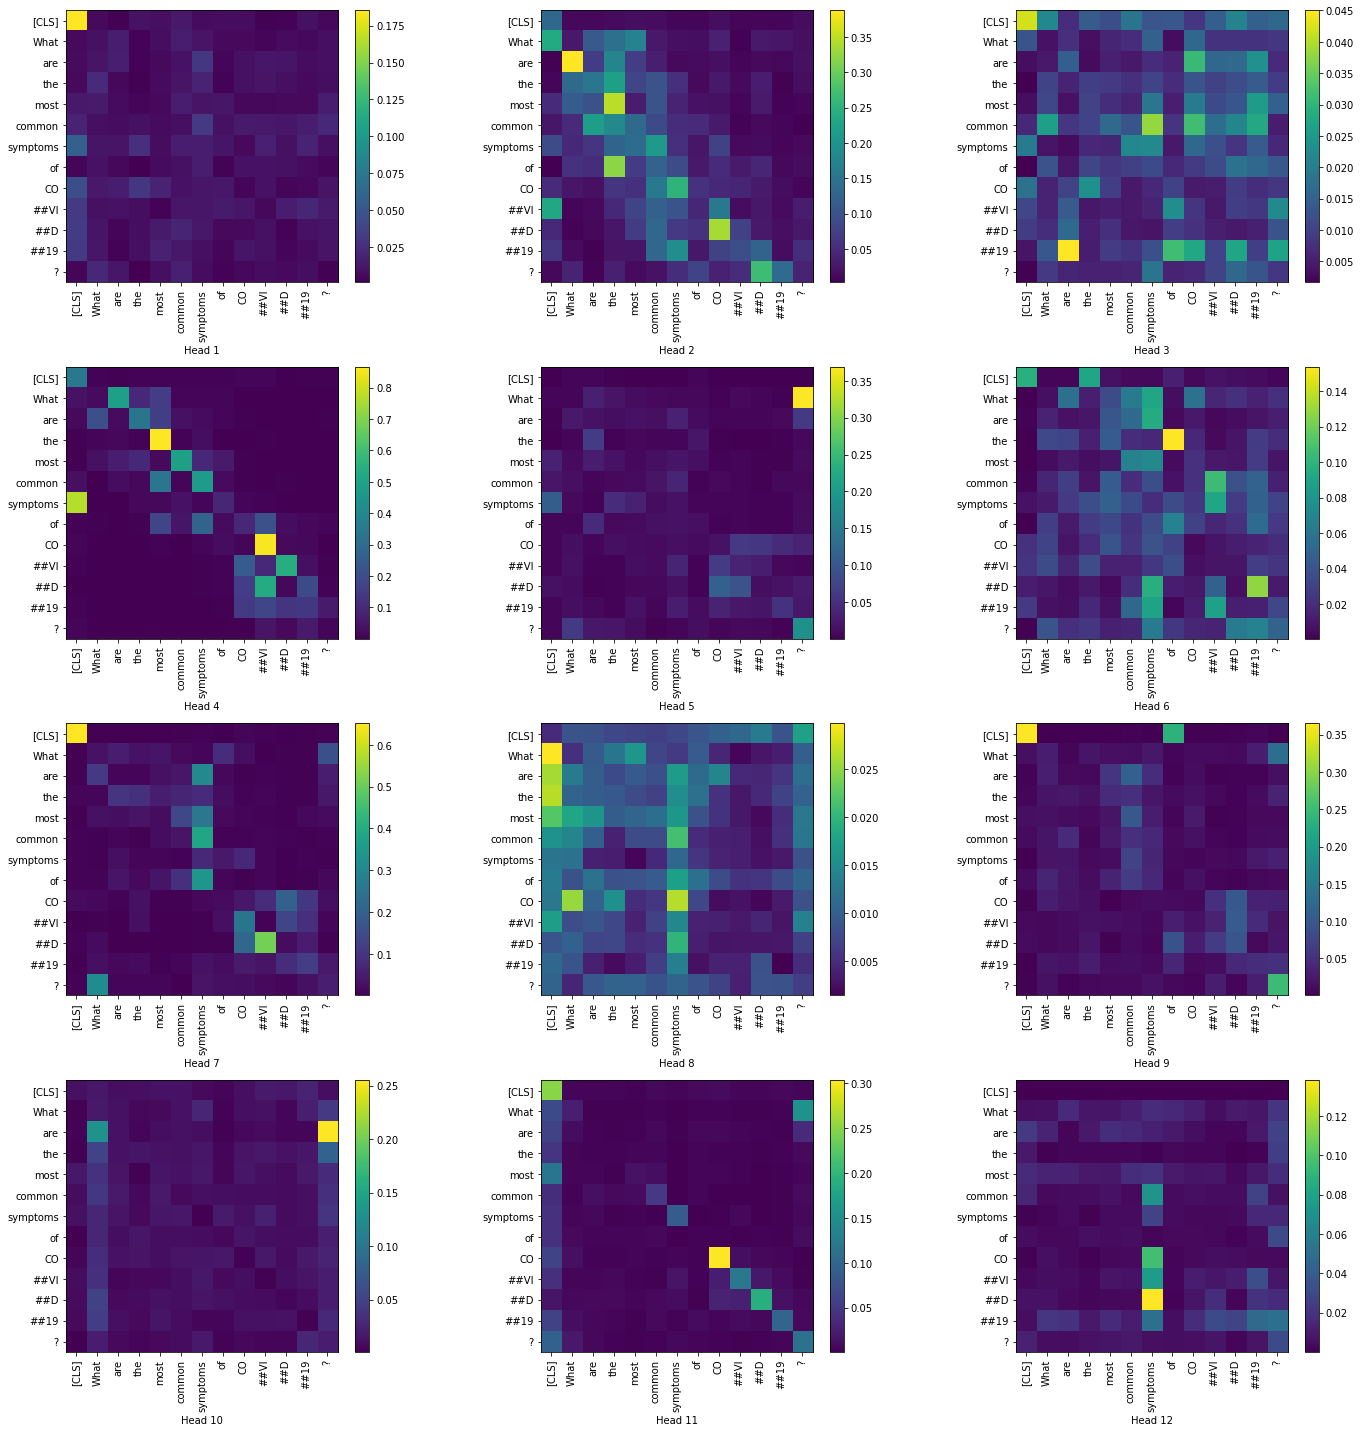

In [22]:
layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

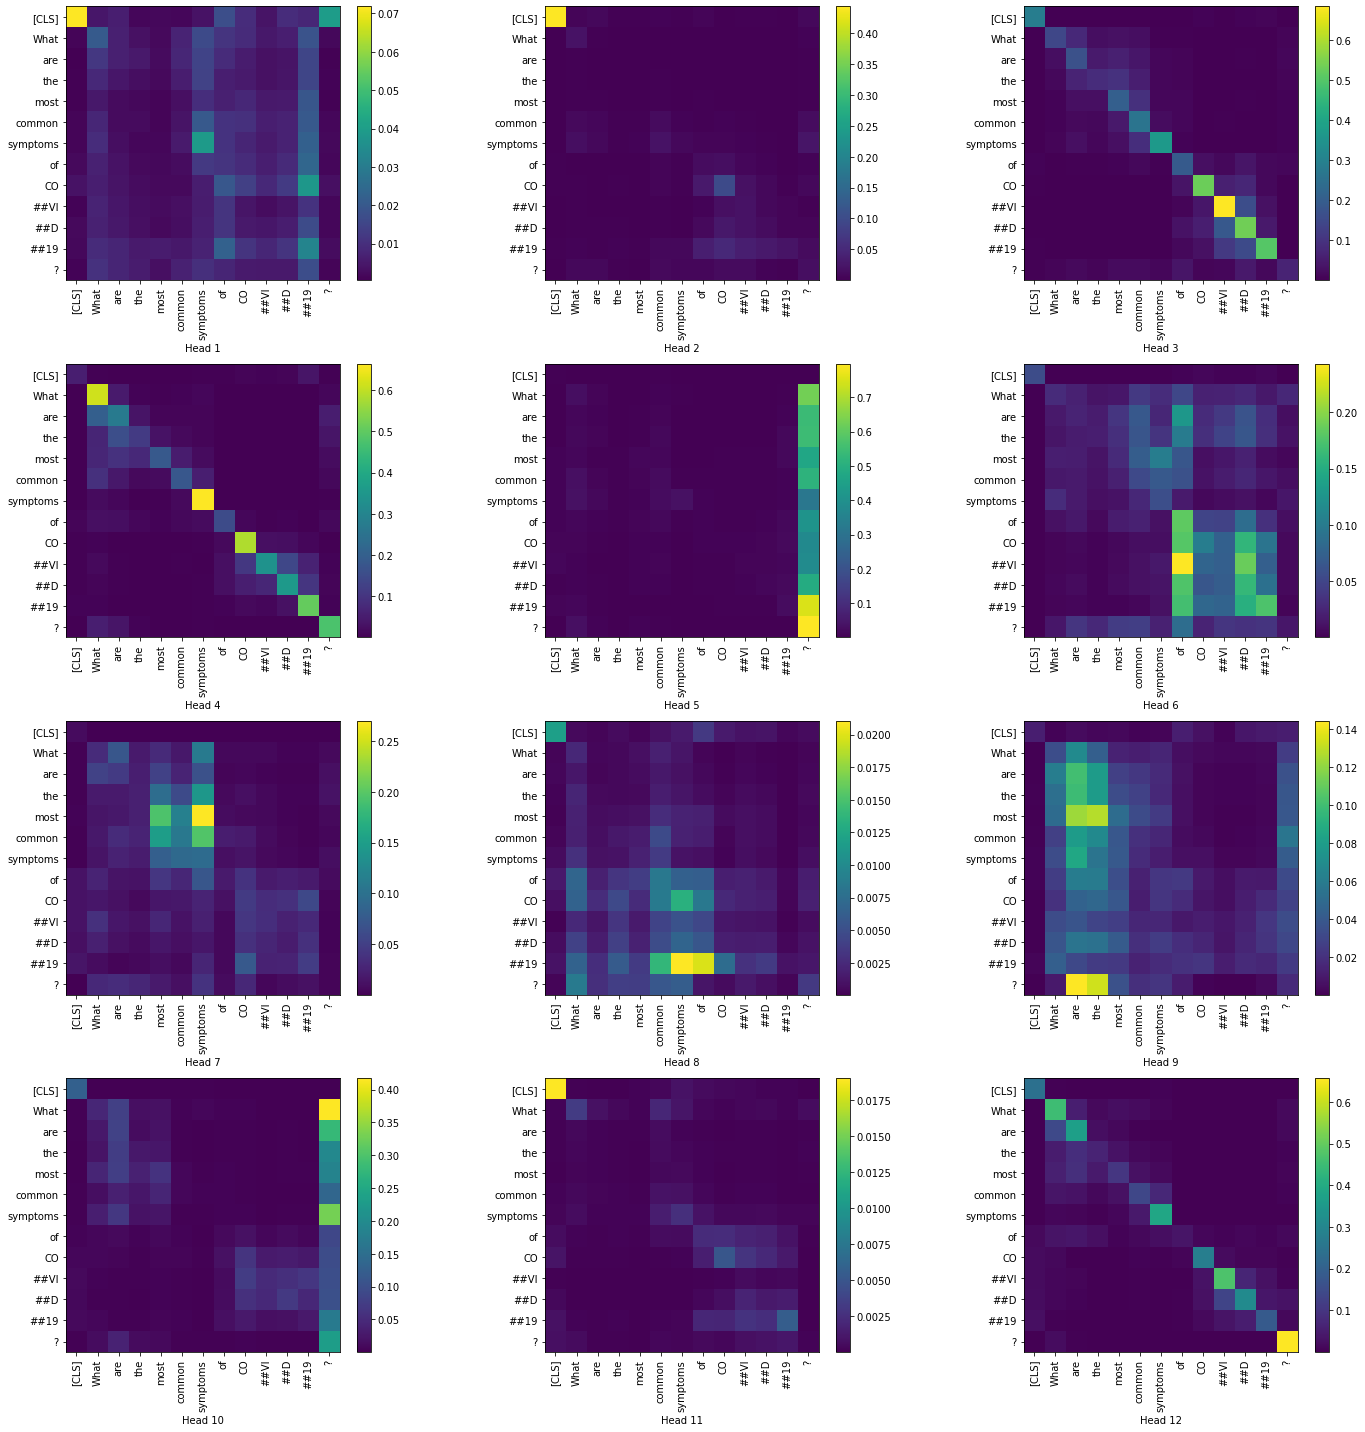

In [23]:
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

Visualizing the summary of all layers across the attention heads

In [24]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

In [25]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [26]:
output_attentions_all = torch.stack(attn_score_qn)

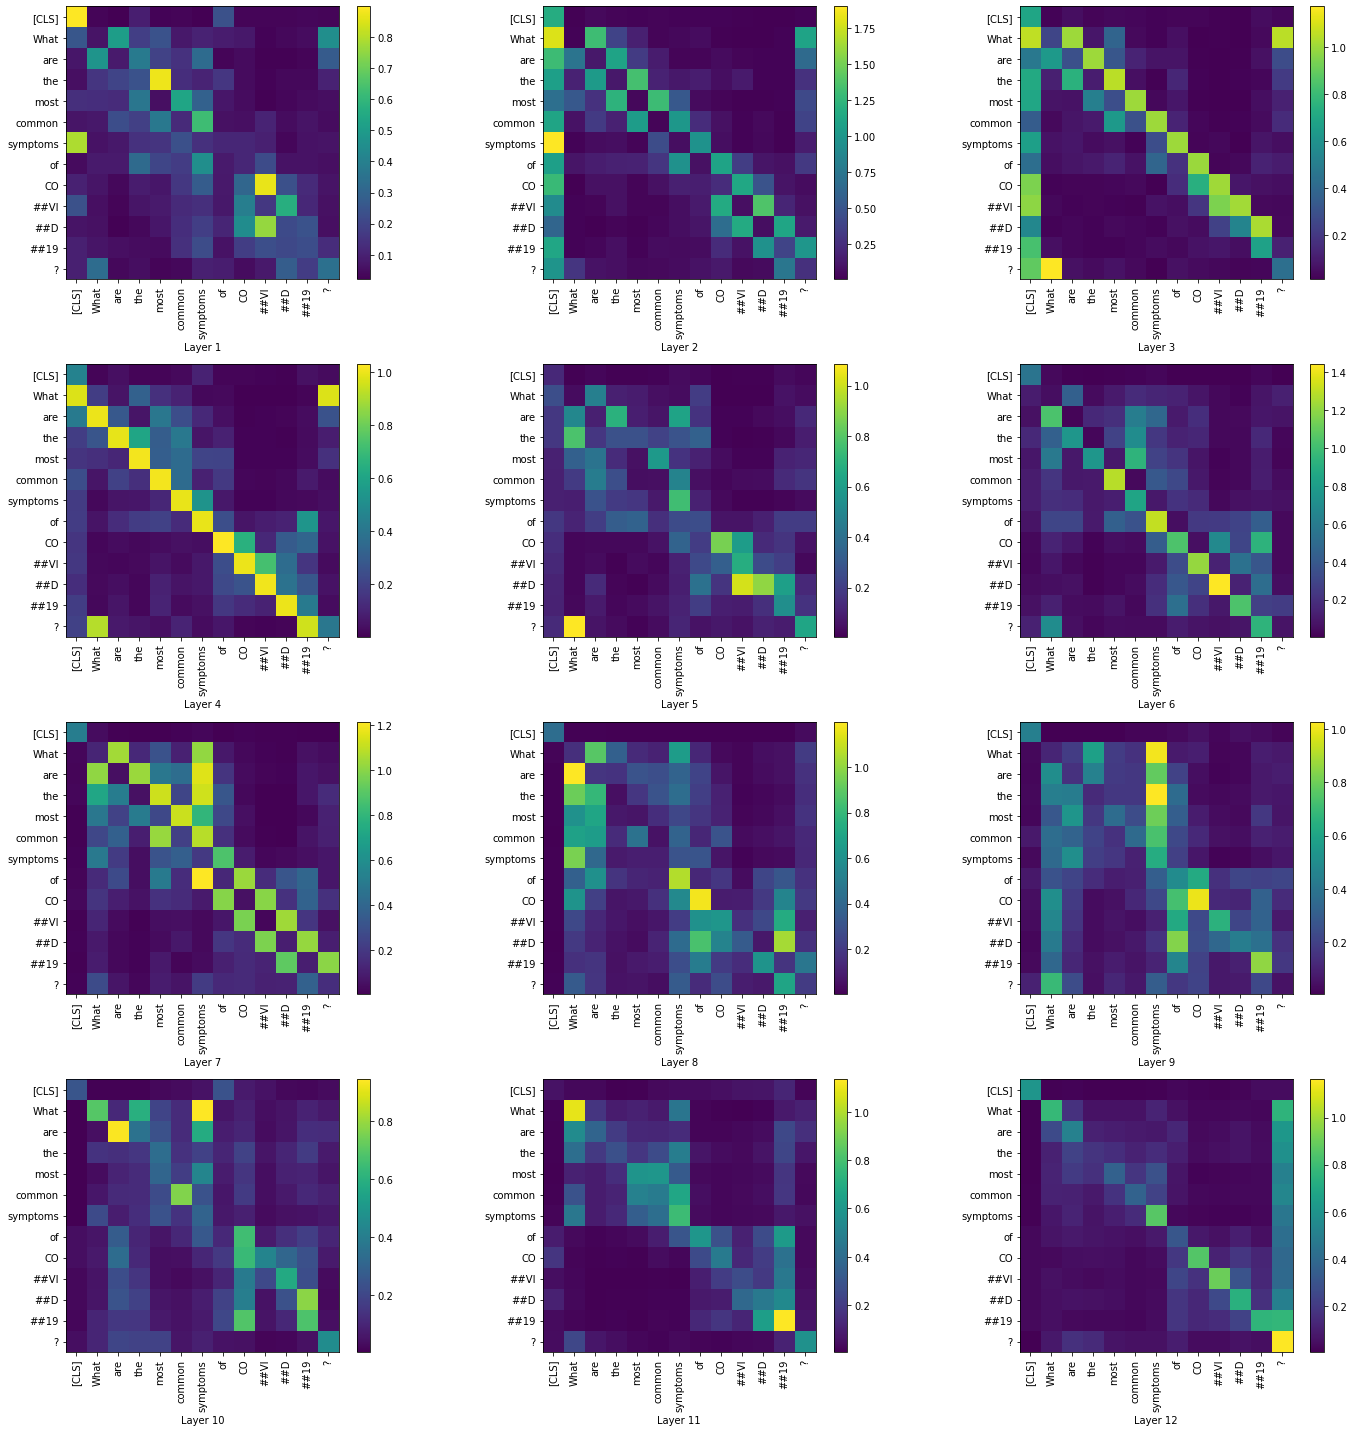

In [27]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')

### After Fine-tuning

In [28]:
train_data = load_dataset("covid_qa_deepset", split='train[:90%]')
val_data = load_dataset("covid_qa_deepset",split='train[90%:]') 

train_contexts, train_questions, train_answers = train_data["context"], train_data["question"], train_data["answers"]
val_contexts, val_questions, val_answers = val_data["context"], val_data["question"], val_data["answers"]

In [29]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text'][0]
        if type(answer['answer_start']) == list:
          answer['answer_start'] = answer['answer_start'][0]
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters
        else:
            answer['answer_end'] = end_idx

    # return answers, contexts

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [30]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [31]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # if None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [32]:
import torch

class CovidQADataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = CovidQADataset(train_encodings)
val_dataset = CovidQADataset(val_encodings)

In [33]:
from torch.utils.data import DataLoader
from transformers import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [34]:
torch.save(model.state_dict(), "/content/drive/MyDrive/DL_CovidQA/bert_base_cased_covidqa_finetuned.pt")

In [ ]:
#model.load_state_dict(torch.load("/content/drive/MyDrive/DL_CovidQA/bert_base_cased_covidqa_finetuned.pt"))

<All keys matched successfully>

In [35]:
em_total, f1_total = evaluate_model(model, val_all, tokenizer, device, answer_getter=covidqa_answergetter)

100%|██████████| 202/202 [01:40<00:00,  2.00it/s]


In [36]:
print(em_total)
print(f1_total)

0.04455445544554455
0.31661904024234233


### Visualizing Attention - BERT with finetuning on COVID-QA

In [37]:
def visualize_token2token_scores(scores_mat, question_tokens, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(question_tokens)))
        ax.set_yticks(range(len(question_tokens)))

        ax.set_xticklabels(question_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(question_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def visualize_token2head_scores(scores_mat, question_tokens):
    fig = plt.figure(figsize=(30, 50))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(question_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(question_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [38]:
answer=val_answers_cov[10]["text"][0]
pred, attn_score, input_ids, _ = eval_qa(val_questions_cov[10], val_contexts_cov[10], answer, 512, tokenizer, model, device)

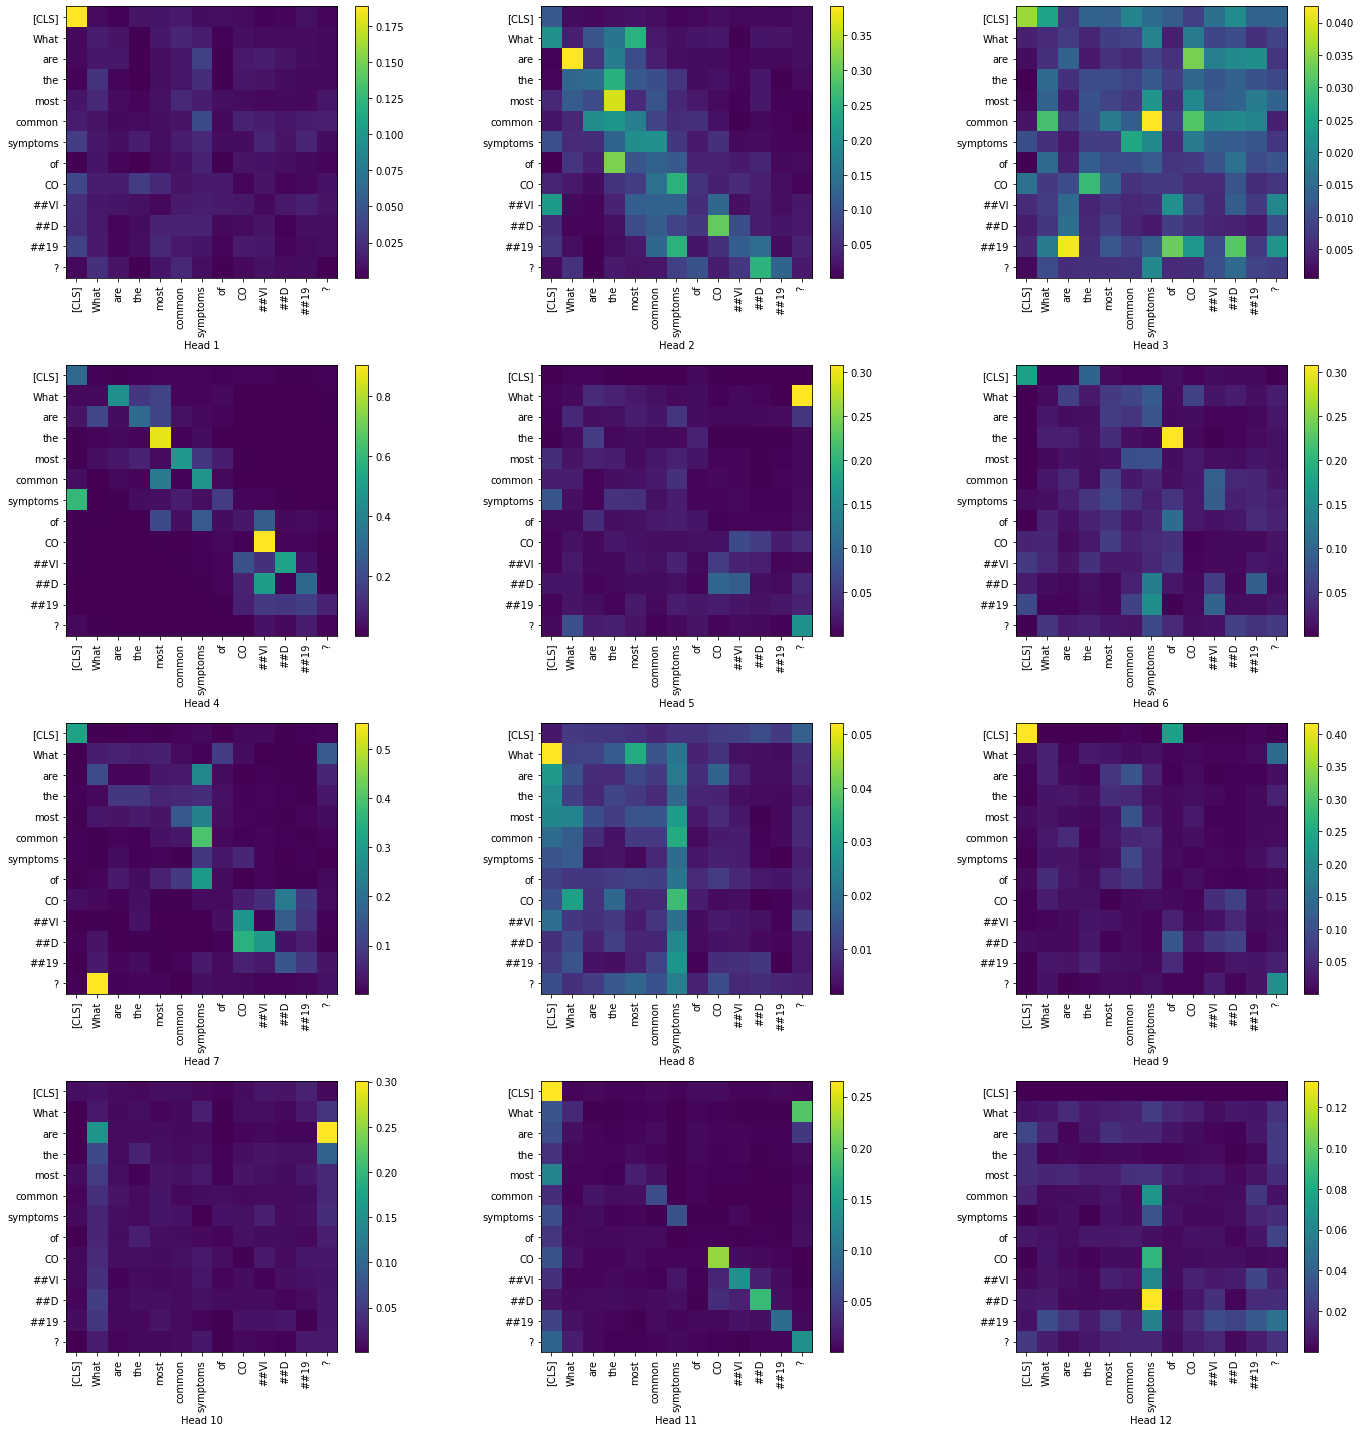

In [39]:
layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

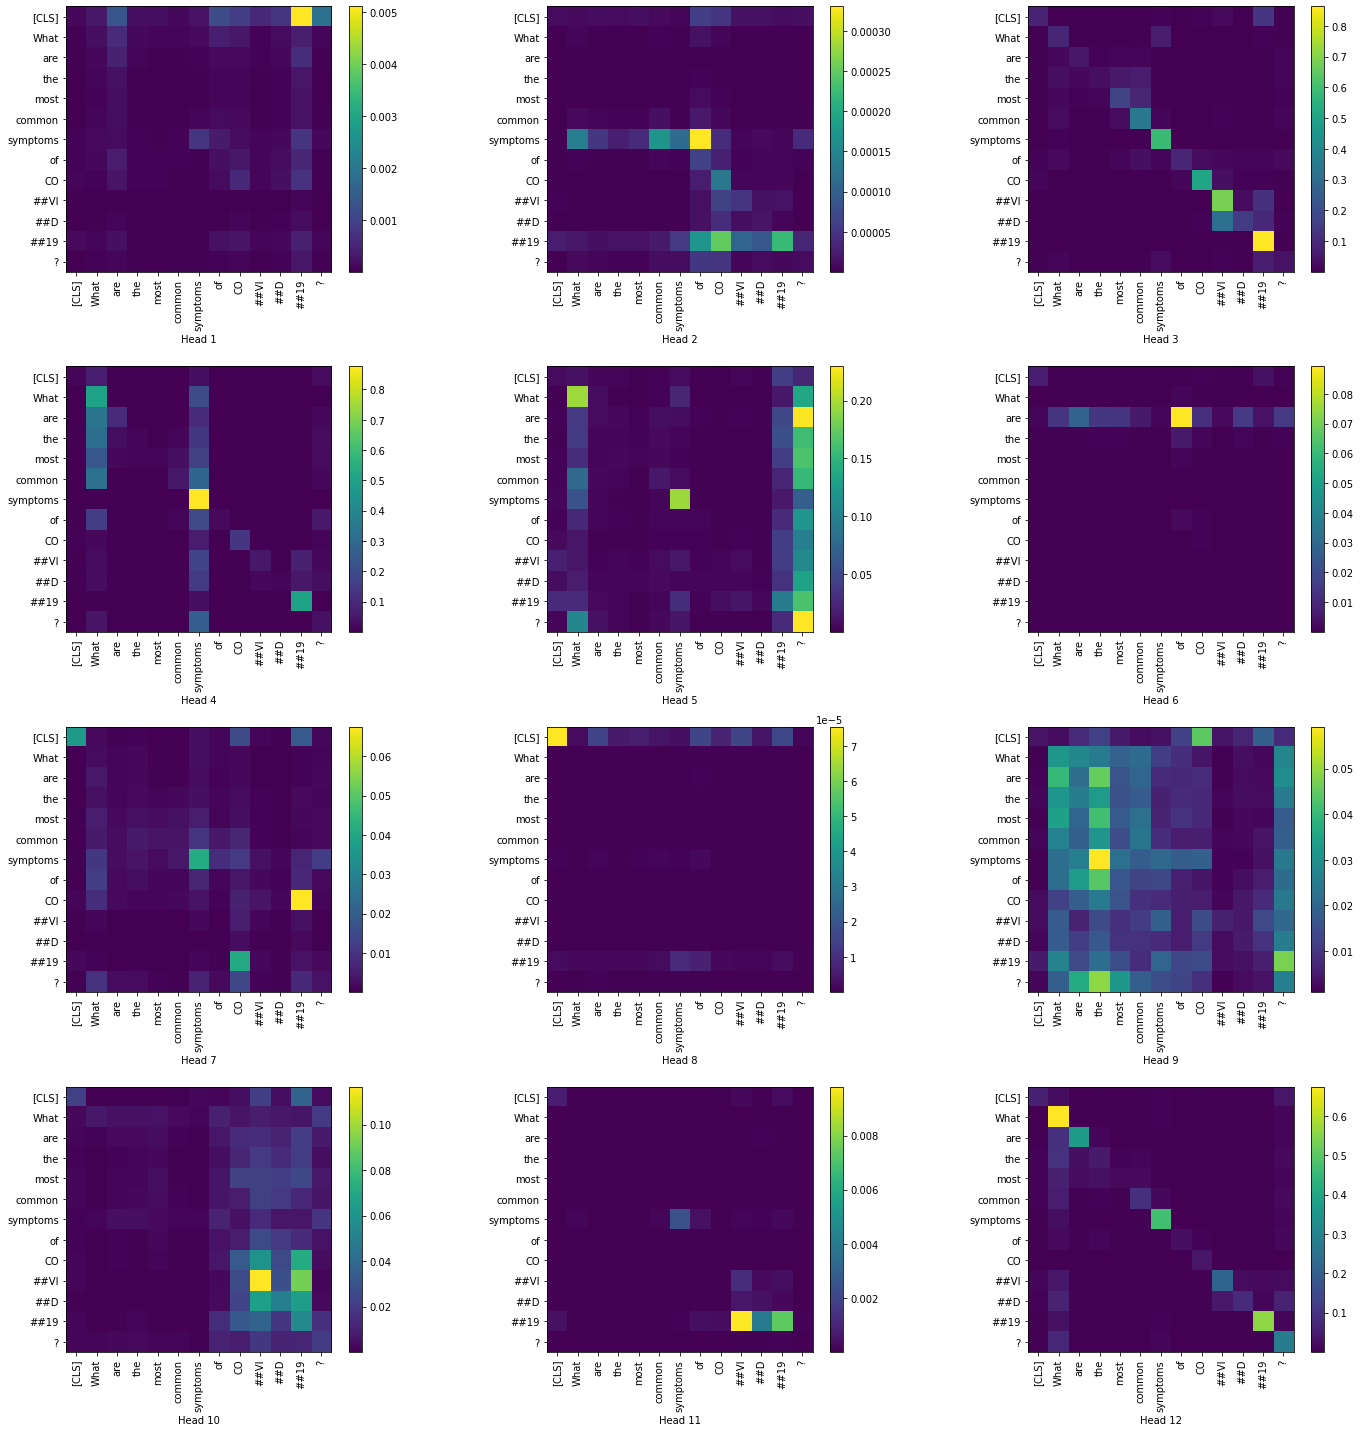

In [40]:
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

In [41]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [42]:
output_attentions_all = torch.stack(attn_score_qn)

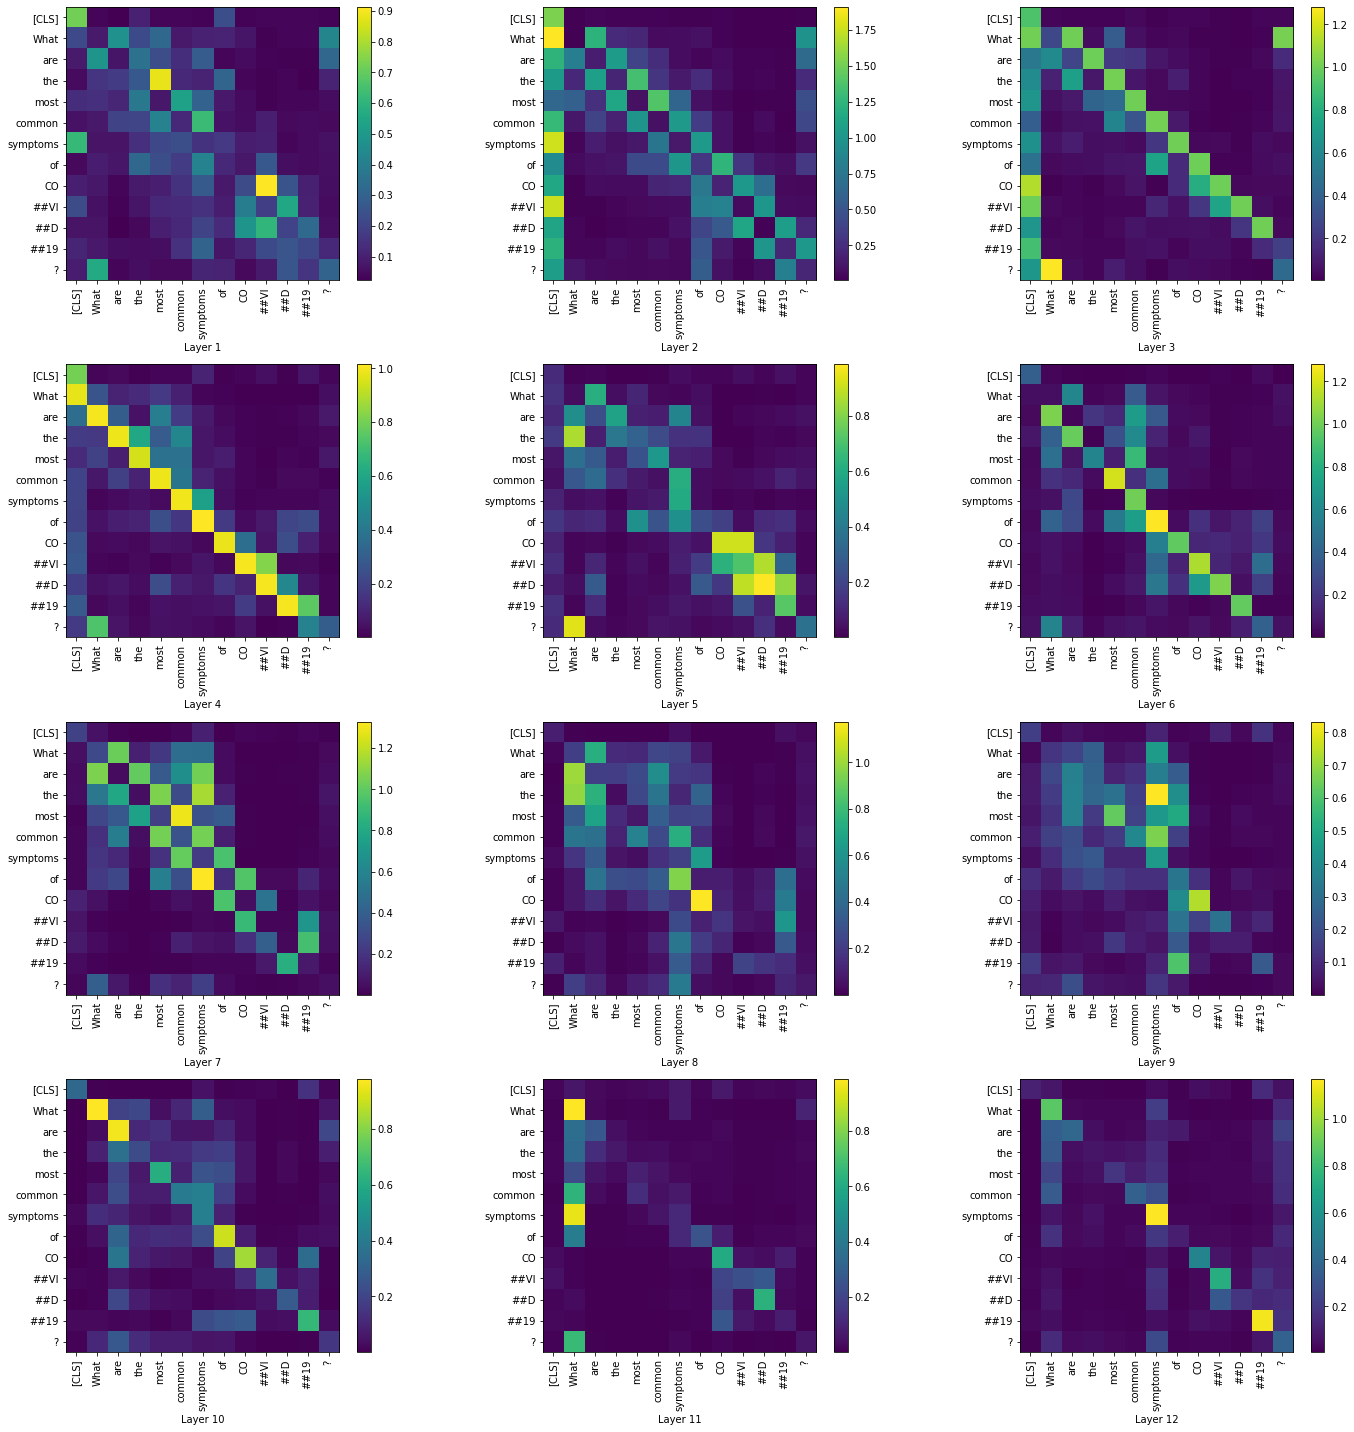

In [43]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')

### With BioBERT

In [44]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("gerardozq/biobert_v1.1_pubmed-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("gerardozq/biobert_v1.1_pubmed-finetuned-squad", output_attentions=True)

model = model.to(device)

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431M [00:00<?, ?B/s]

In [45]:
em_total, f1_total = evaluate_model(model, val_all, tokenizer, device, answer_getter=covidqa_answergetter)

100%|██████████| 202/202 [01:40<00:00,  2.01it/s]


In [46]:
print(em_total)
print(f1_total)

0.1188118811881188
0.3584029180942841


### Visualizing Attention - BioBERT with no fine-tuned on COVID-QA

In [47]:
answer=val_answers_cov[10]["text"][0]
pred, attn_score, input_ids, _ = eval_qa(val_questions_cov[10], val_contexts_cov[10], answer, 512, tokenizer, model, device)

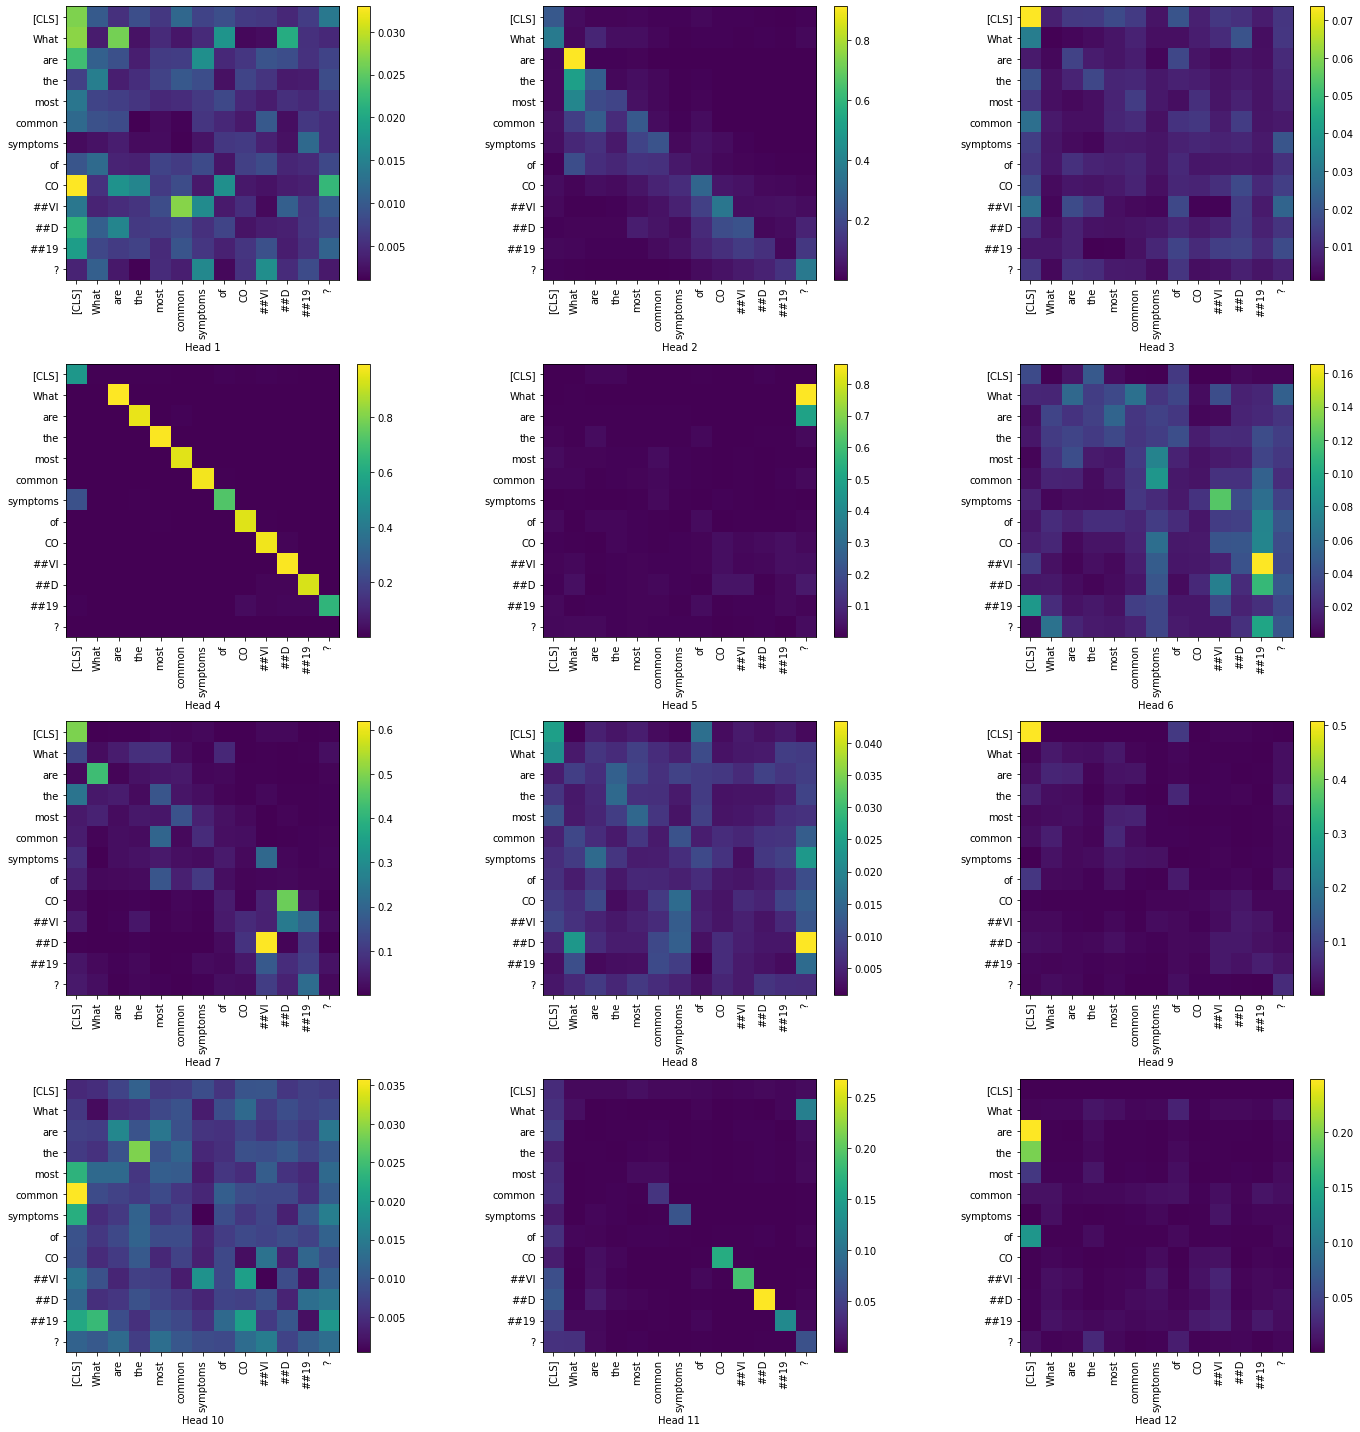

In [48]:
layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

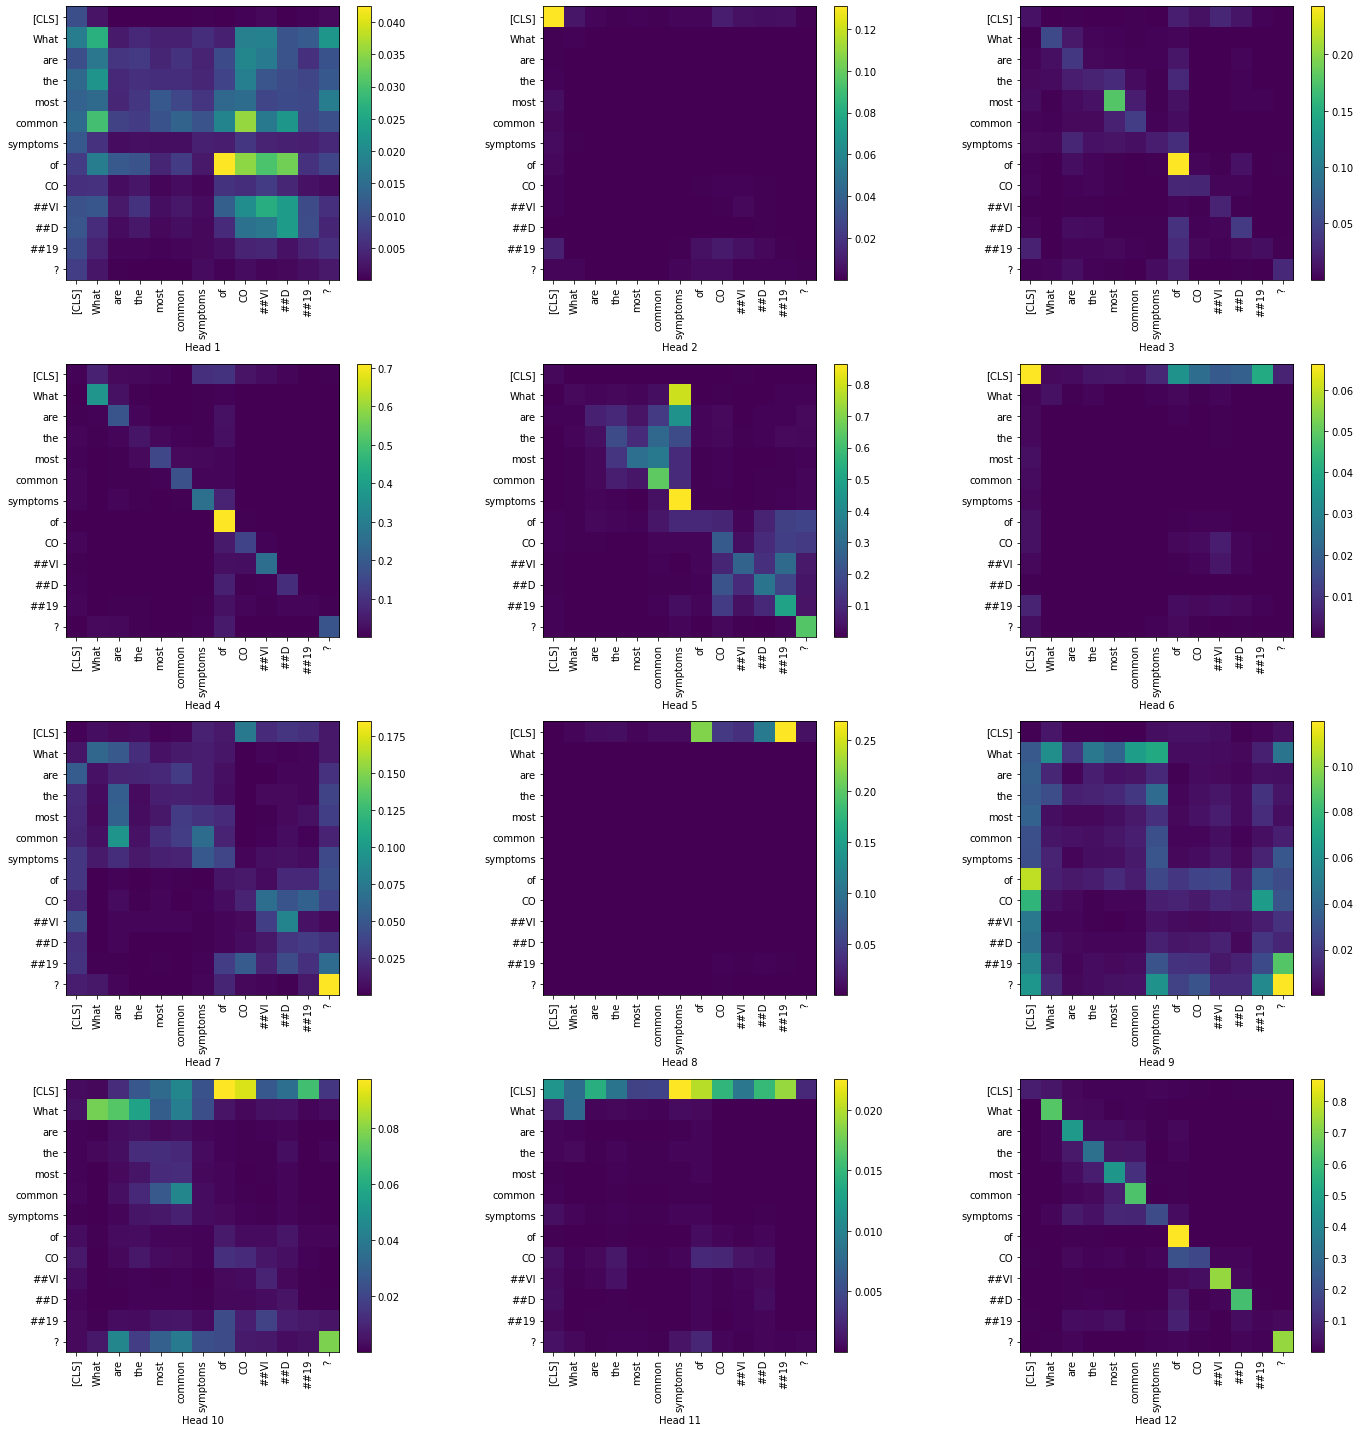

In [49]:
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

In [50]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [51]:
output_attentions_all = torch.stack(attn_score_qn)

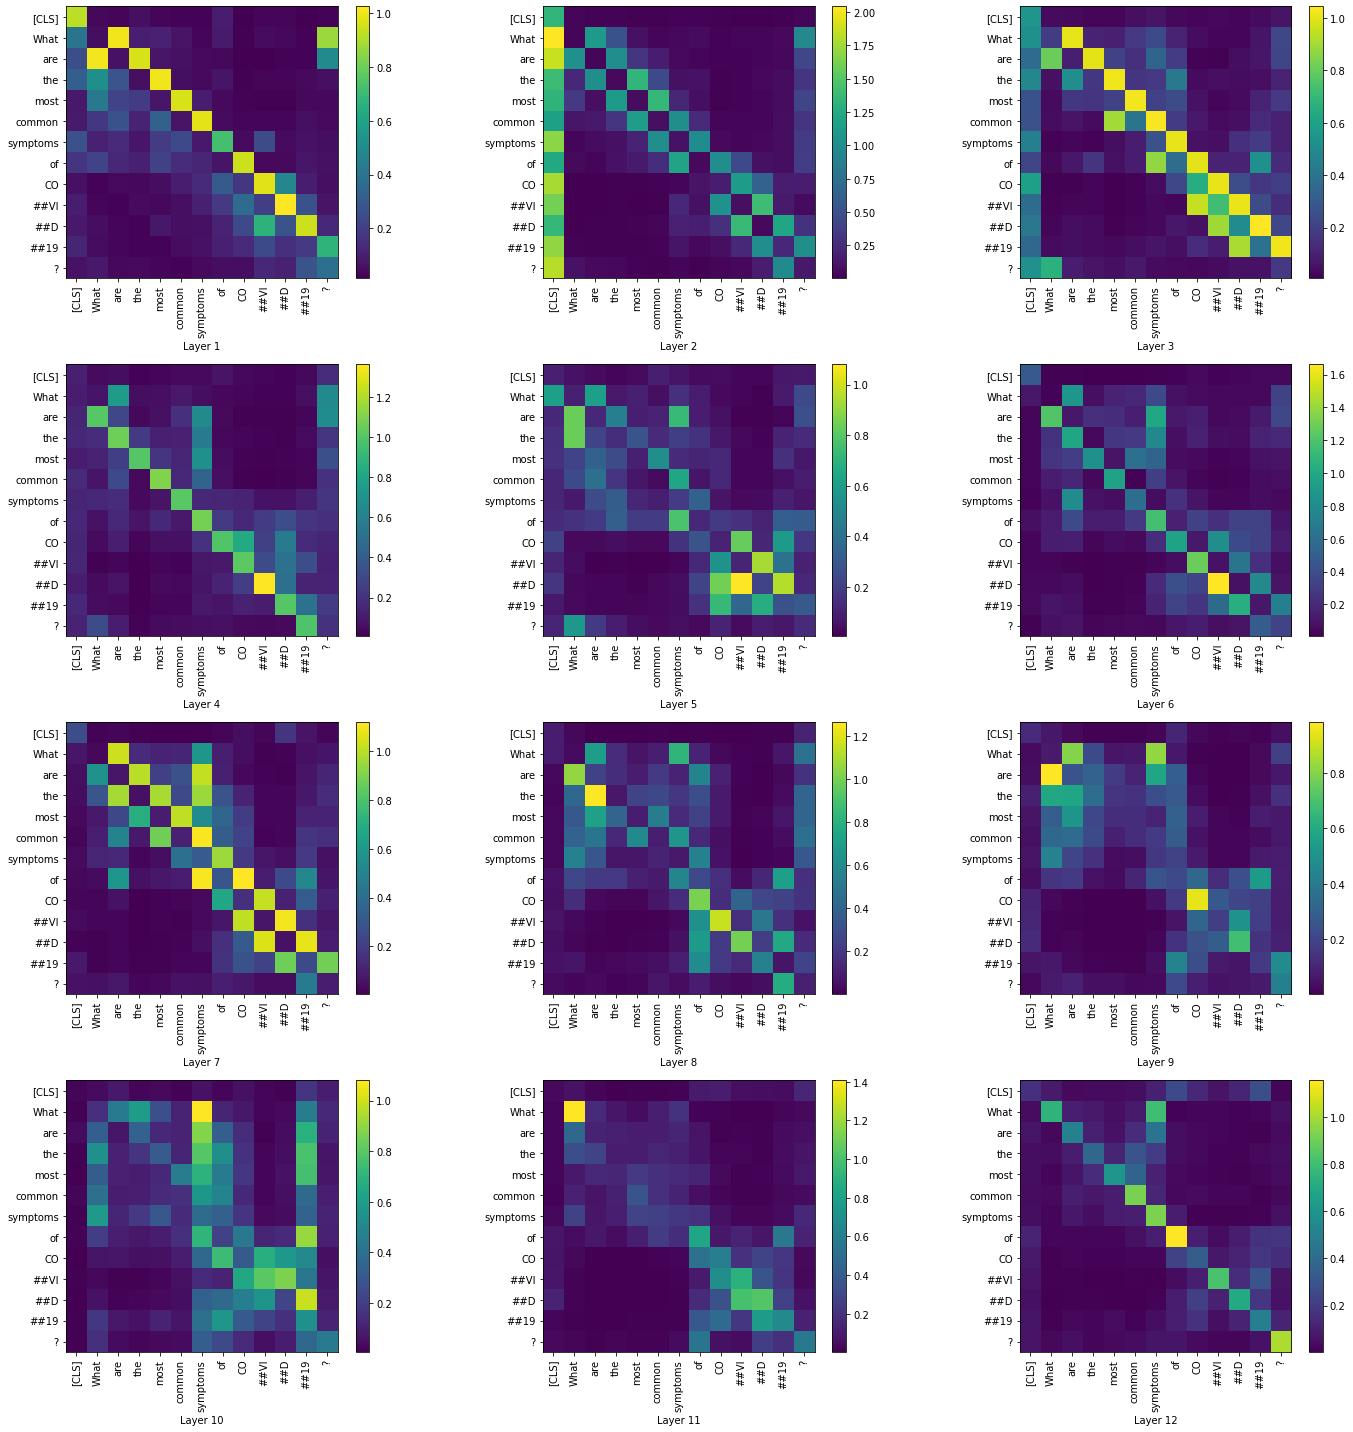

In [52]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')

### BioBERT - After Finetuning

In [54]:
model.load_state_dict(torch.load("/content/drive/MyDrive/DL_CovidQA/biobert_base_covidqa_finetuned.pt"))

<All keys matched successfully>

In [55]:
em_total, f1_total = evaluate_model(model, val_all, tokenizer, device, answer_getter=covidqa_answergetter)

100%|██████████| 202/202 [01:41<00:00,  1.99it/s]


In [56]:
print(em_total)
print(f1_total)

0.18811881188118812
0.5151754561465287


### Visualizing Attention - BioBERT fine-tuned on COVID-QA

In [57]:
answer=val_answers_cov[10]["text"][0]
pred, attn_score, input_ids, _ = eval_qa(val_questions_cov[10], val_contexts_cov[10], answer, 512, tokenizer, model, device)

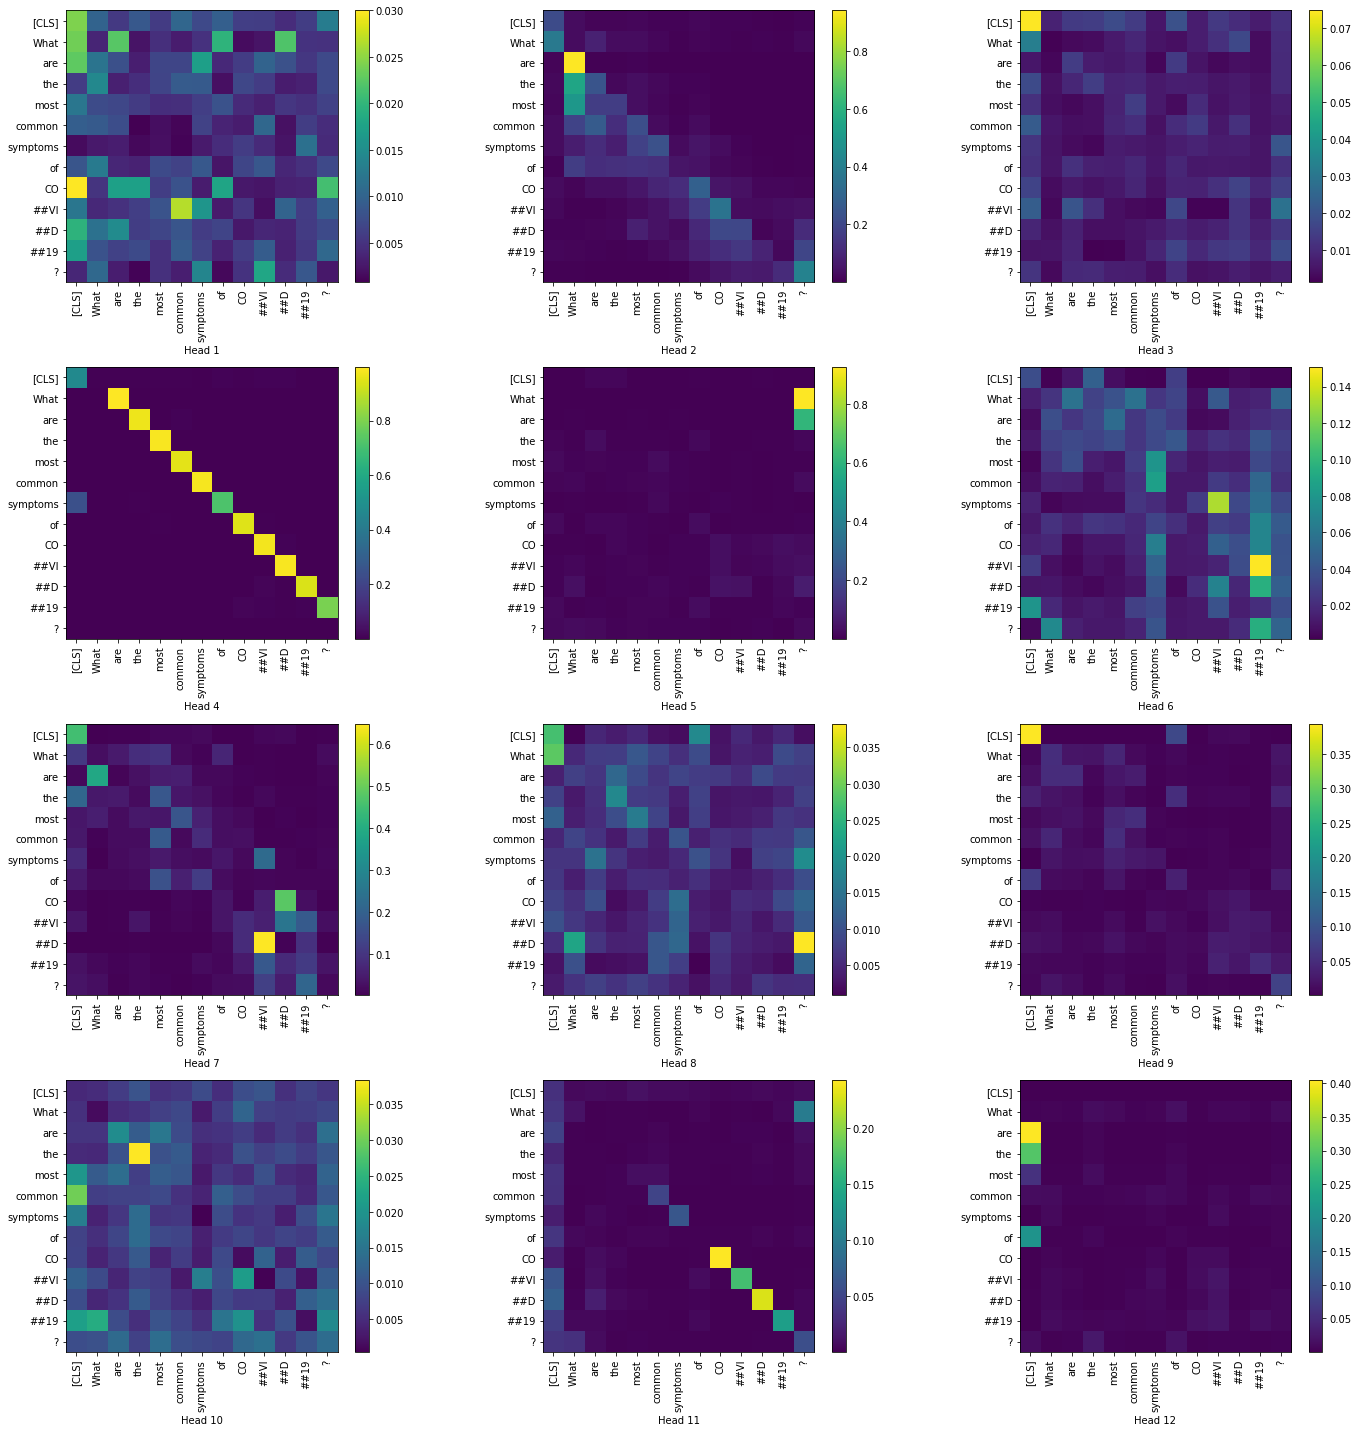

In [58]:
layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

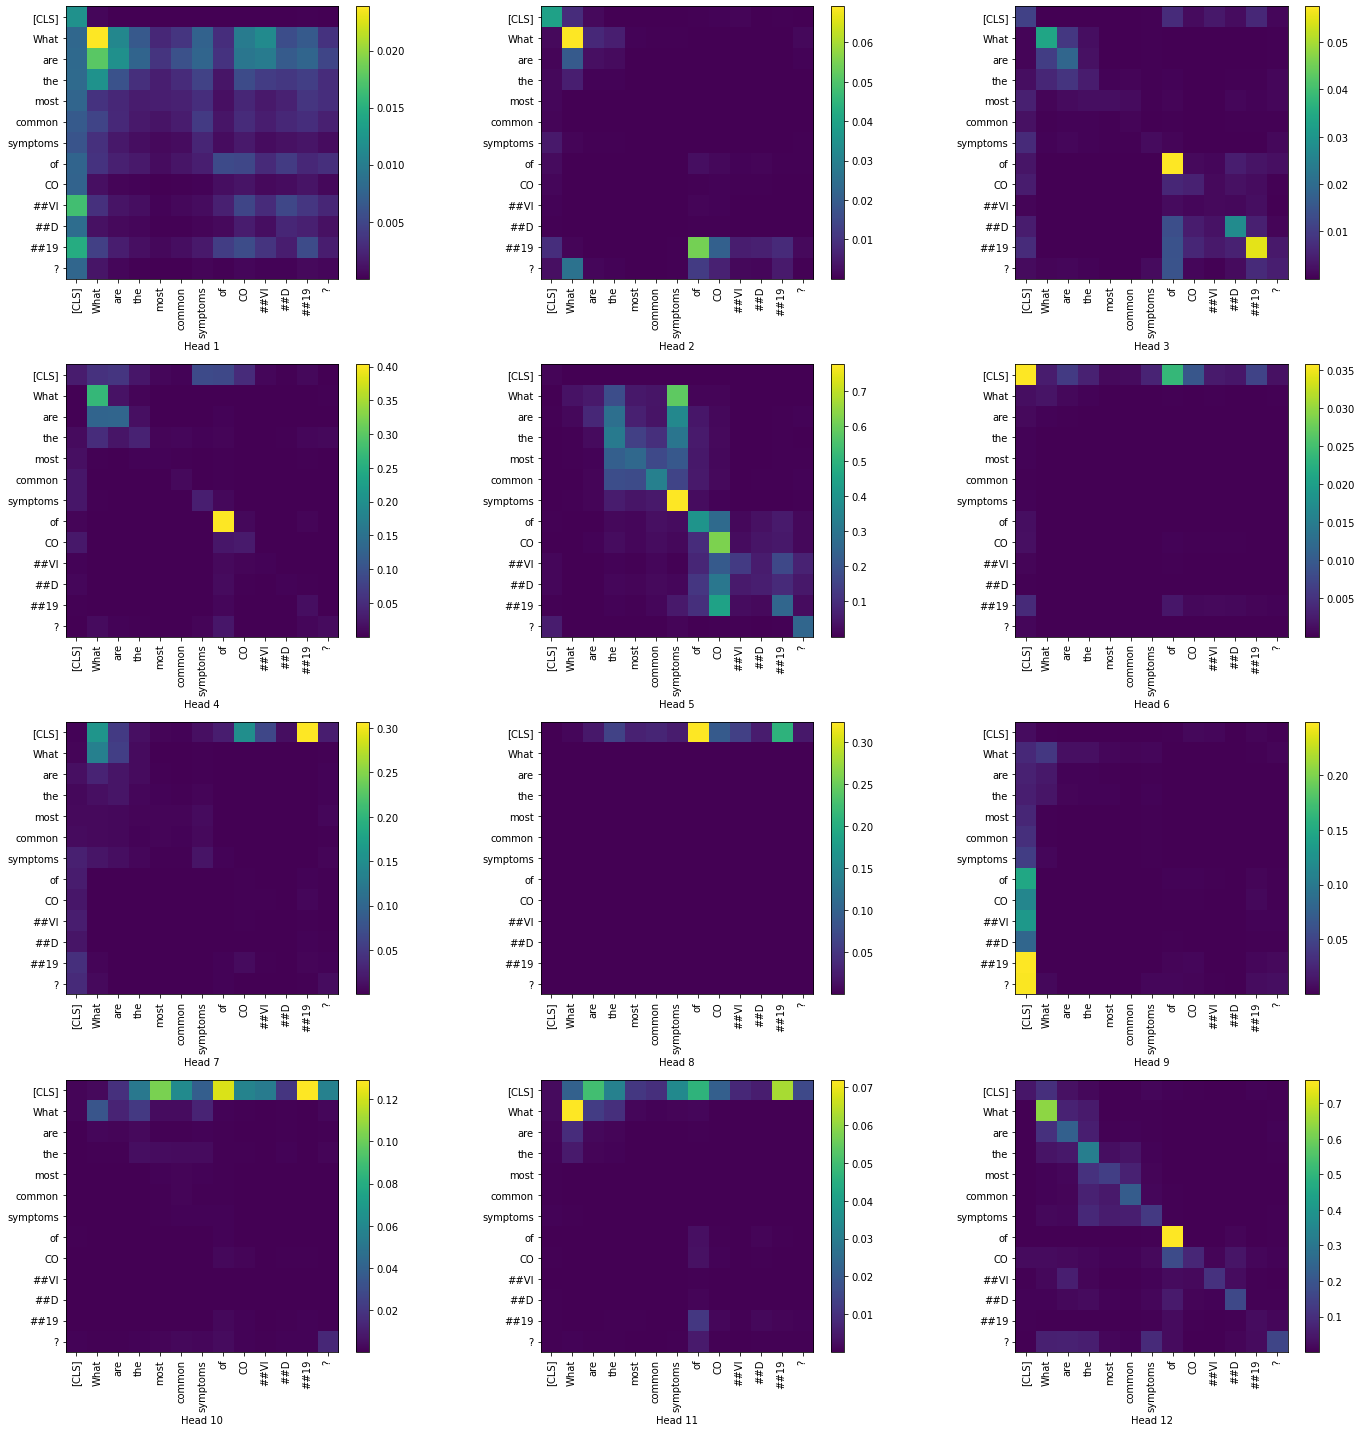

In [59]:
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

In [60]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [61]:
output_attentions_all = torch.stack(attn_score_qn)

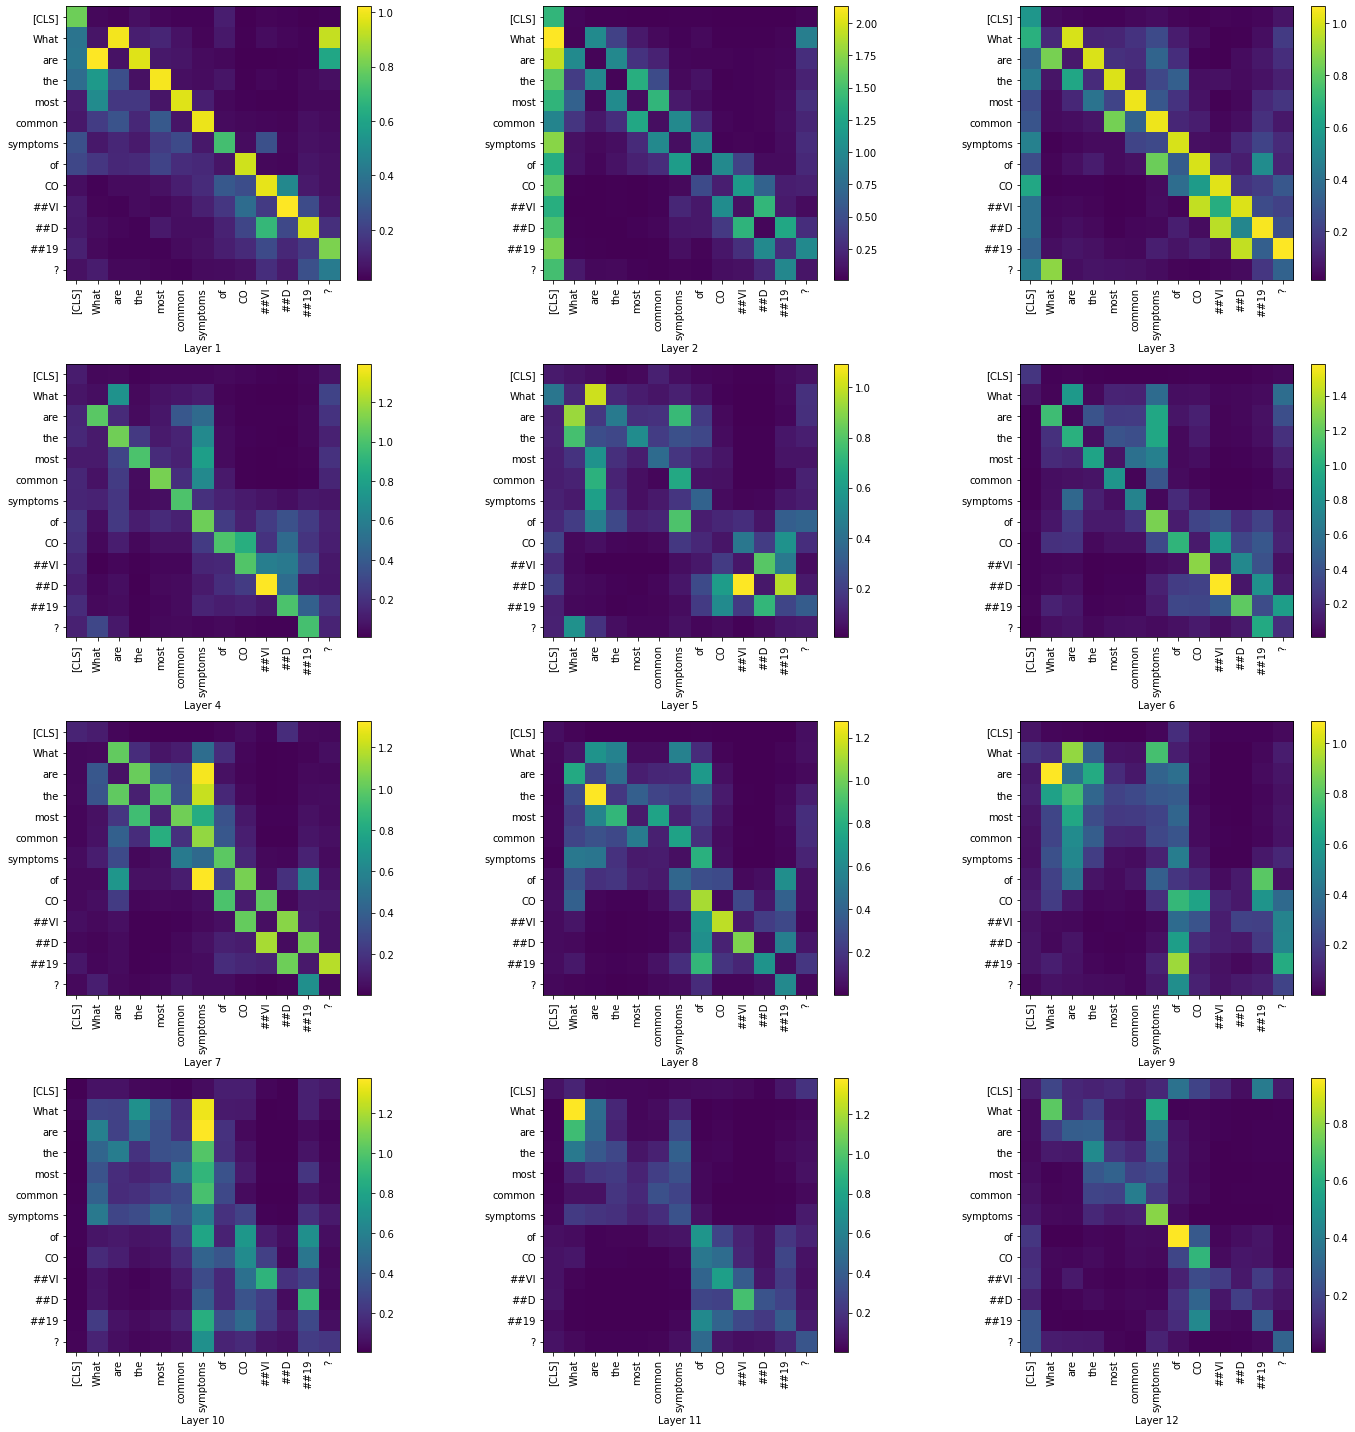

In [62]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')

## Out of Domain test on DROP

https://huggingface.co/datasets/drop


In [101]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("Seongkyu/bert-base-cased-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("Seongkyu/bert-base-cased-finetuned-squad", output_attentions=True)

model.to(device)
model = model.eval()

In [130]:
import json
from pathlib import Path

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad('/content/drive/MyDrive/DL_CovidQA/squad2-0_format_data_DROP_train.json')
val_contexts, val_questions, val_answers = read_squad('/content/drive/MyDrive/DL_CovidQA/squad2-0_format_data_DROP_dev.json')

In [131]:
# using a sample of data for training and validation
train_contexts, train_questions, train_answers = train_contexts[:10000], train_questions[:10000], train_answers[:10000]
val_contexts, val_questions, val_answers = val_contexts[:2000], val_questions[:2000], val_answers[:2000]

In [132]:
# def cosmos_answergetter(answer):
#   return answer

def drop_answergetter(answer):
  if len(answer["text"]) > 0:
    return answer["text"]
  else:
    return ""

In [133]:
val_all = val_contexts, val_questions, val_answers

In [68]:
em_total, f1_total = evaluate_model(model, val_all, tokenizer, device, answer_getter=drop_answergetter)

100%|██████████| 2000/2000 [01:16<00:00, 26.29it/s]


In [69]:
print(em_total)
print(f1_total)

0.103
0.18234009250553038


### Visualizing Attention - BERT with no finetuning on DROP-QA

In [80]:
val_questions[10]

'Who sent a diplomatic mission to Ava in 1745?'

In [79]:
val_answers[10]["text"]

'The Siamese'

In [81]:
answer=val_answers[10]["text"]
pred, attn_score, input_ids, _ = eval_qa(val_questions[10], val_contexts[10], answer, 512, tokenizer, model, device)

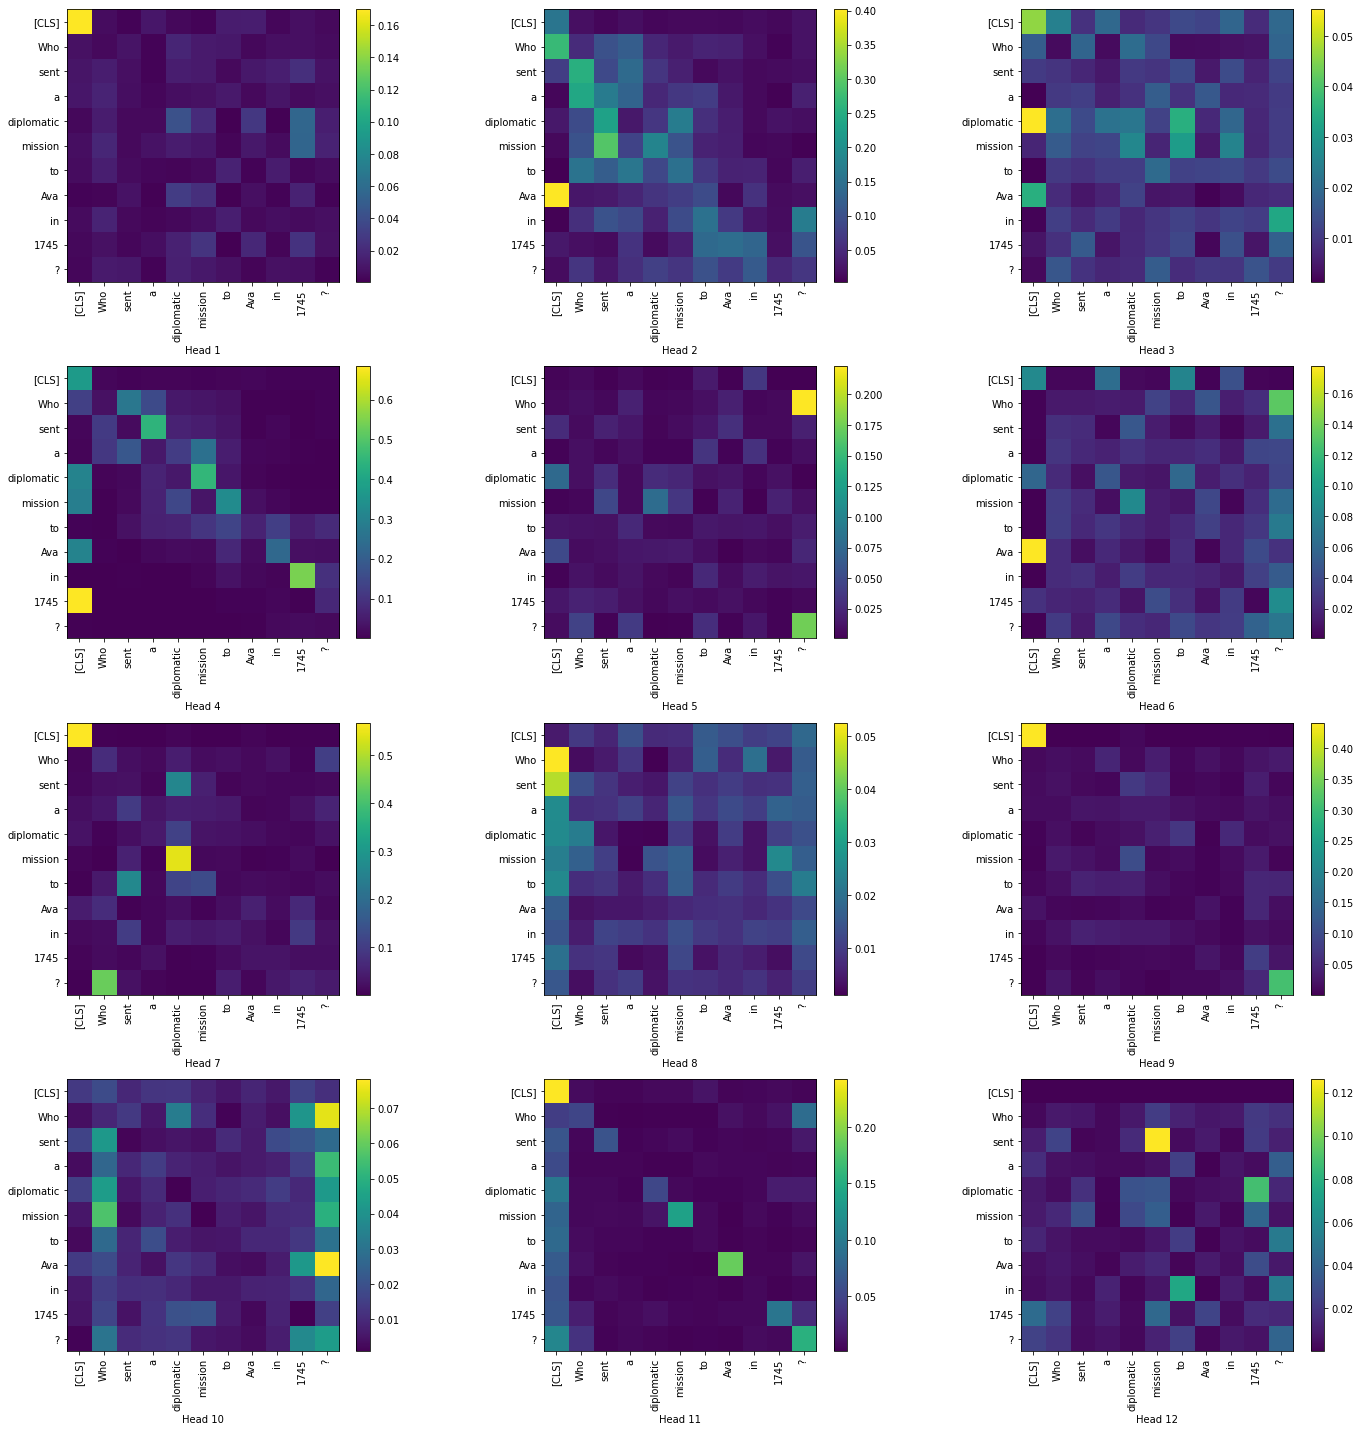

In [82]:
layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

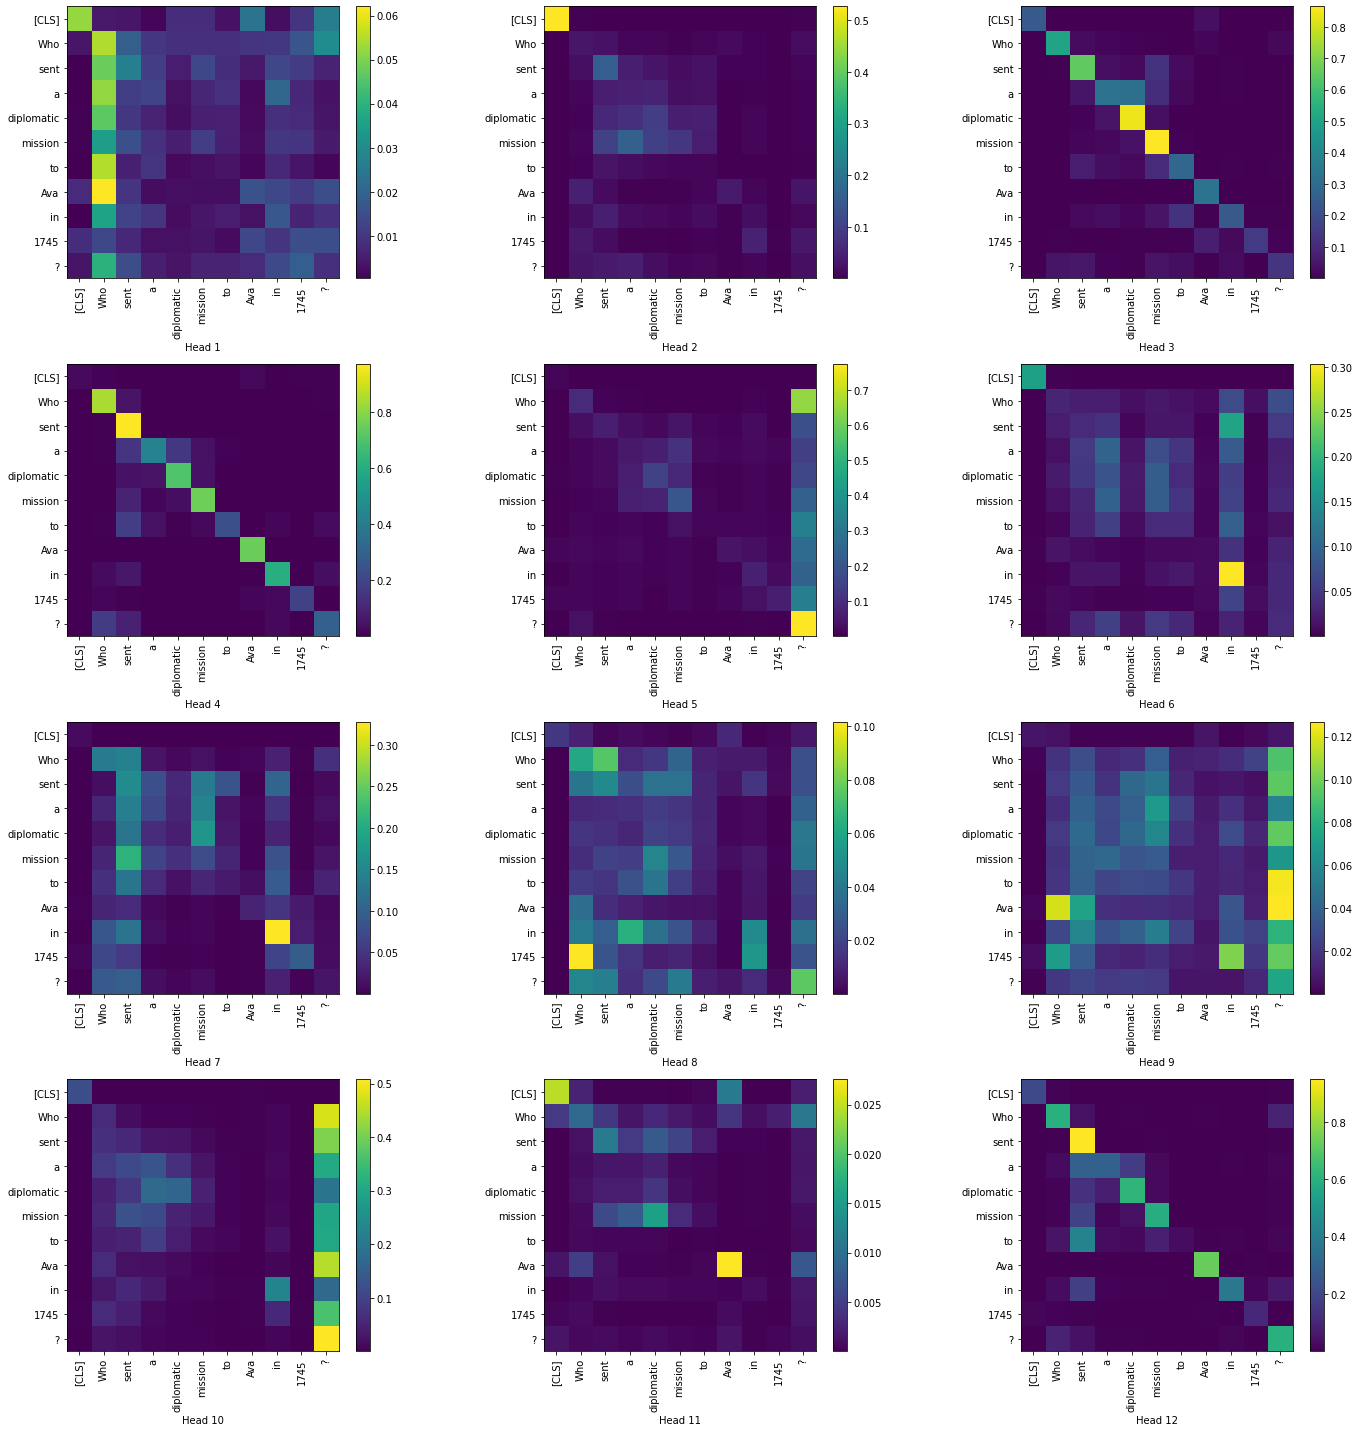

In [83]:
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

In [84]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [85]:
output_attentions_all = torch.stack(attn_score_qn)

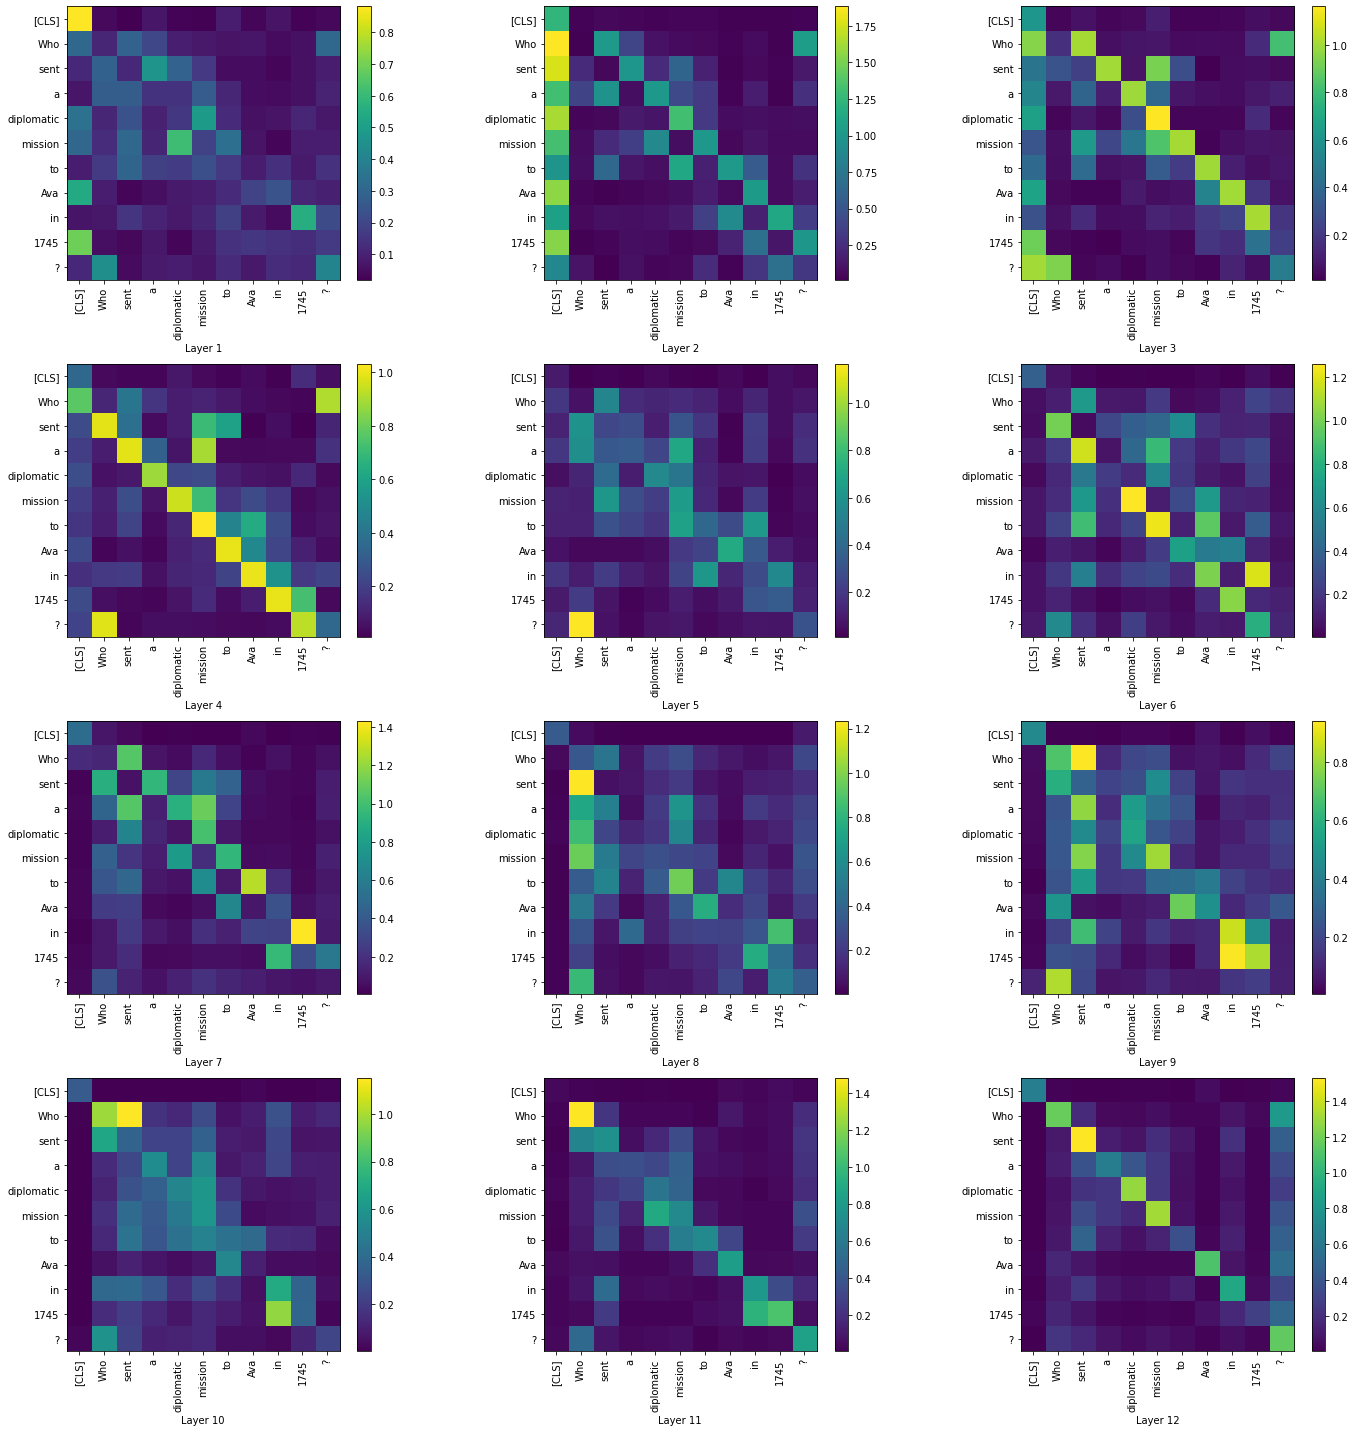

In [86]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')

### Finetuning BERT on DROP-QA

In [134]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer
        if type(answer['answer_start']) == list:
          if len(answer['answer_start']) > 0:
            answer['answer_start'] = answer['answer_start'][0]
          else:
            answer['answer_start'] = 0
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters
        else:
            answer['answer_end'] = end_idx

    # return answers, contexts

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [135]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [136]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # if None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [137]:
import torch

class DROPDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = DROPDataset(train_encodings)
val_dataset = DROPDataset(val_encodings)

In [138]:
from tqdm import tqdm

In [139]:
len(train_loader)

1250

In [140]:
from torch.utils.data import DataLoader
from transformers import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in trange(3):
    for batch in tqdm(train_loader, total=len(train_loader)):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

100%|██████████| 3/3 [53:47<00:00, 1075.74s/it]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [141]:
torch.save(model.state_dict(), "/content/drive/MyDrive/DL_CovidQA/bert_base_cased_drop_qa_finetuned.pt")

In [96]:
model.load_state_dict(torch.load("/content/drive/MyDrive/DL_CovidQA/bert_base_cased_drop_qa_finetuned.pt"))

<All keys matched successfully>

In [142]:
em_total, f1_total = evaluate_model(model, val_all, tokenizer, device, answer_getter=drop_answergetter)

100%|██████████| 2000/2000 [01:11<00:00, 27.82it/s]


In [143]:
print(em_total)
print(f1_total)

0.244
0.3630924208511594


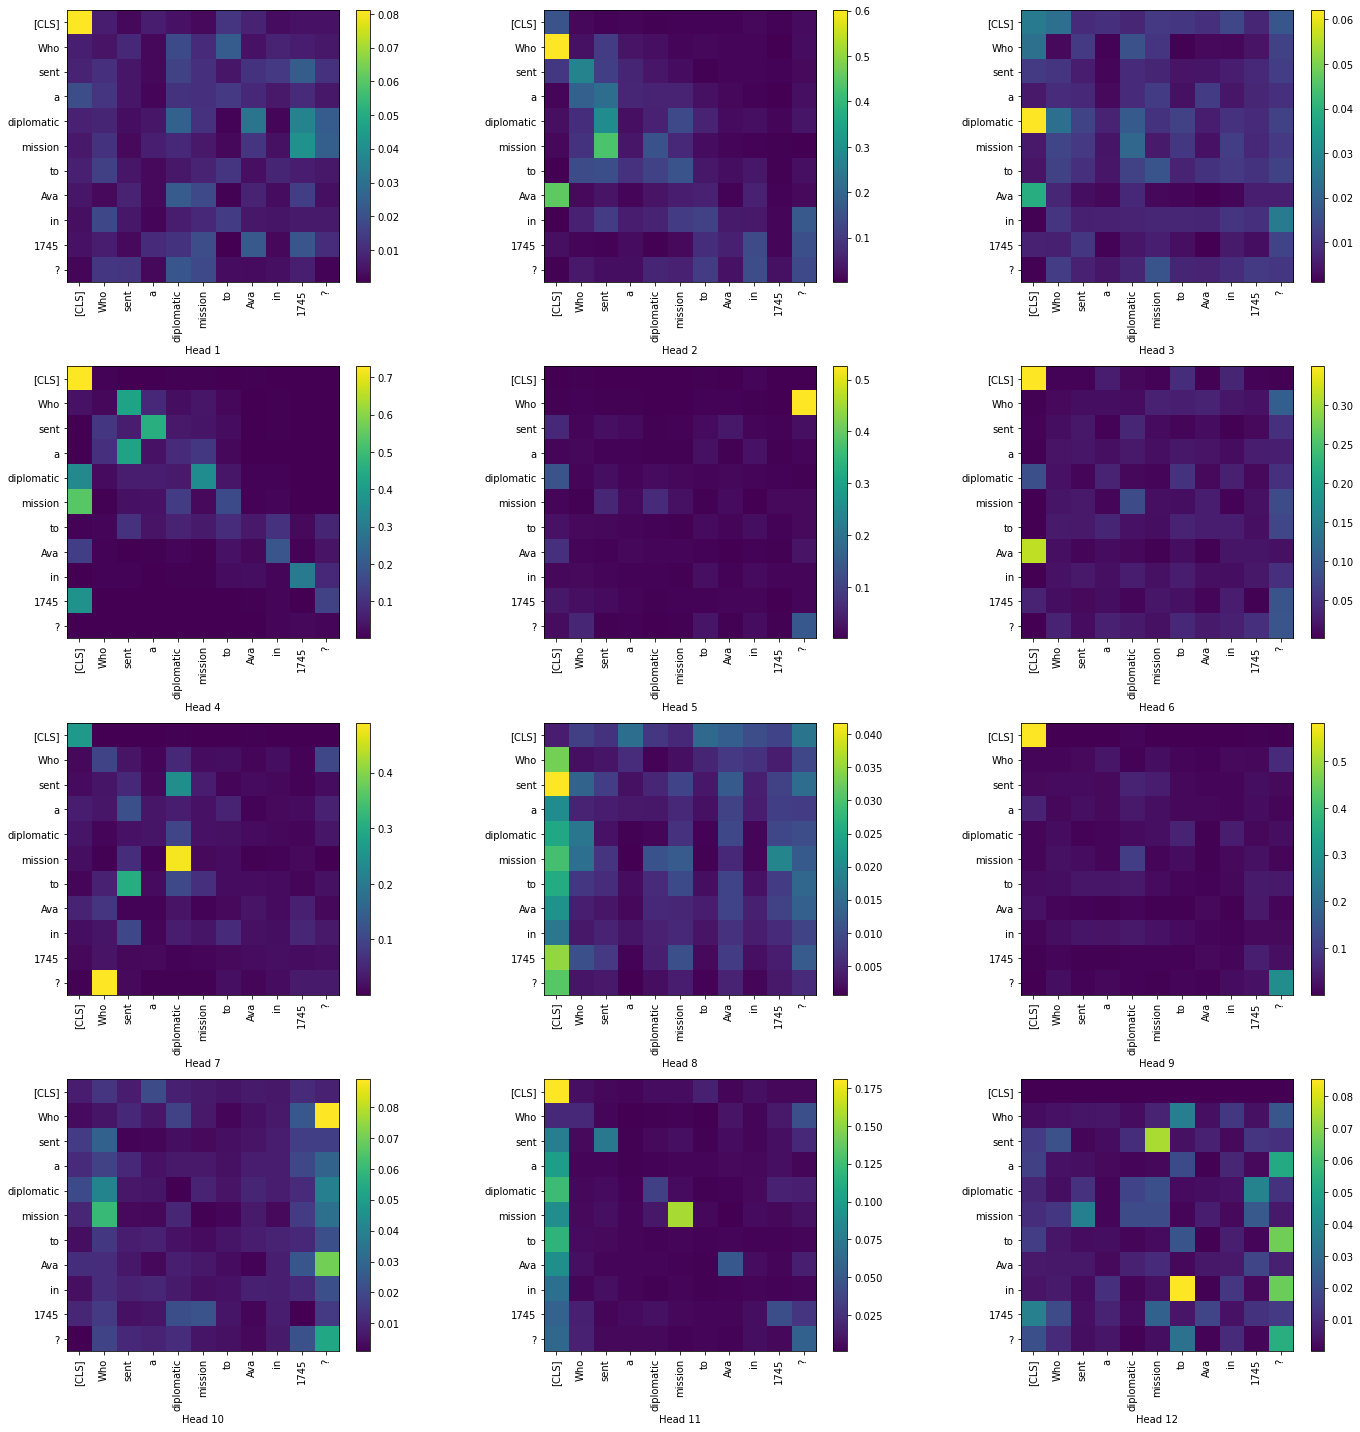

In [144]:
answer=val_answers[10]["text"]
pred, attn_score, input_ids, _ = eval_qa(val_questions[10], val_contexts[10], answer, 512, tokenizer, model, device)

layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

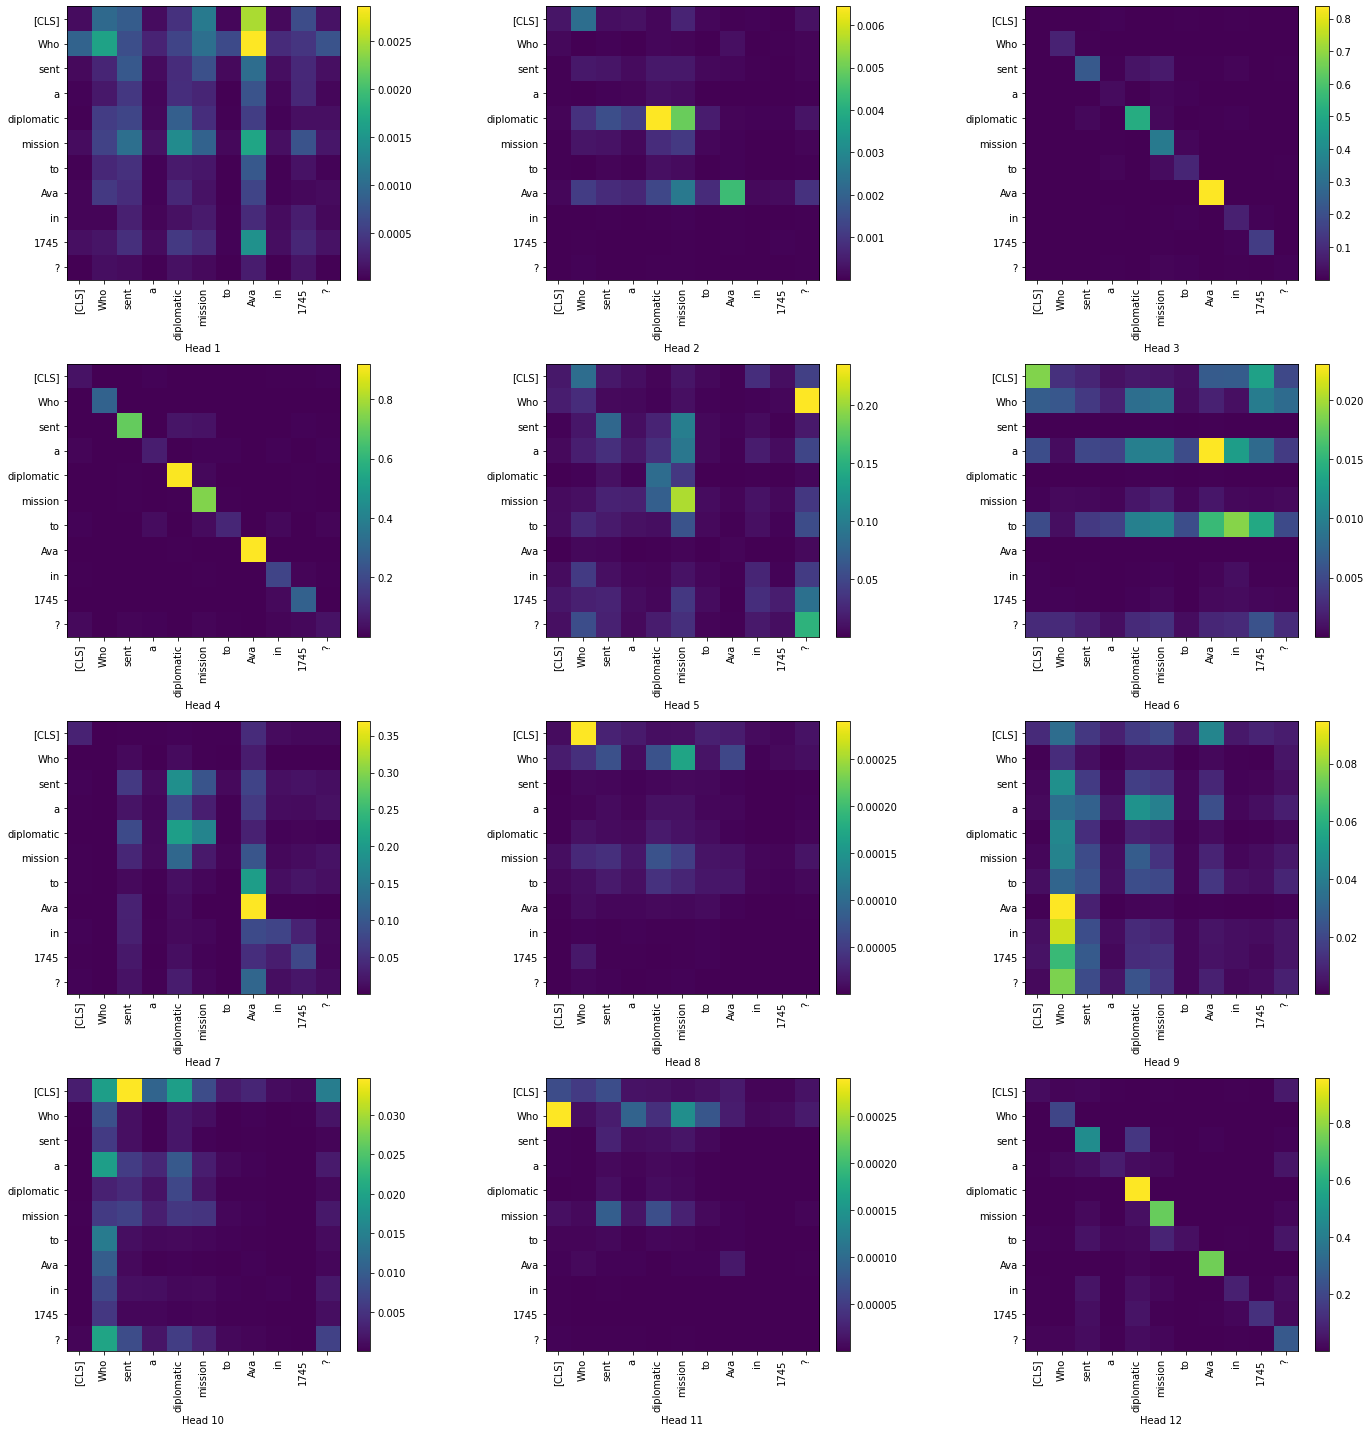

In [145]:
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

In [146]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [147]:
output_attentions_all = torch.stack(attn_score_qn)

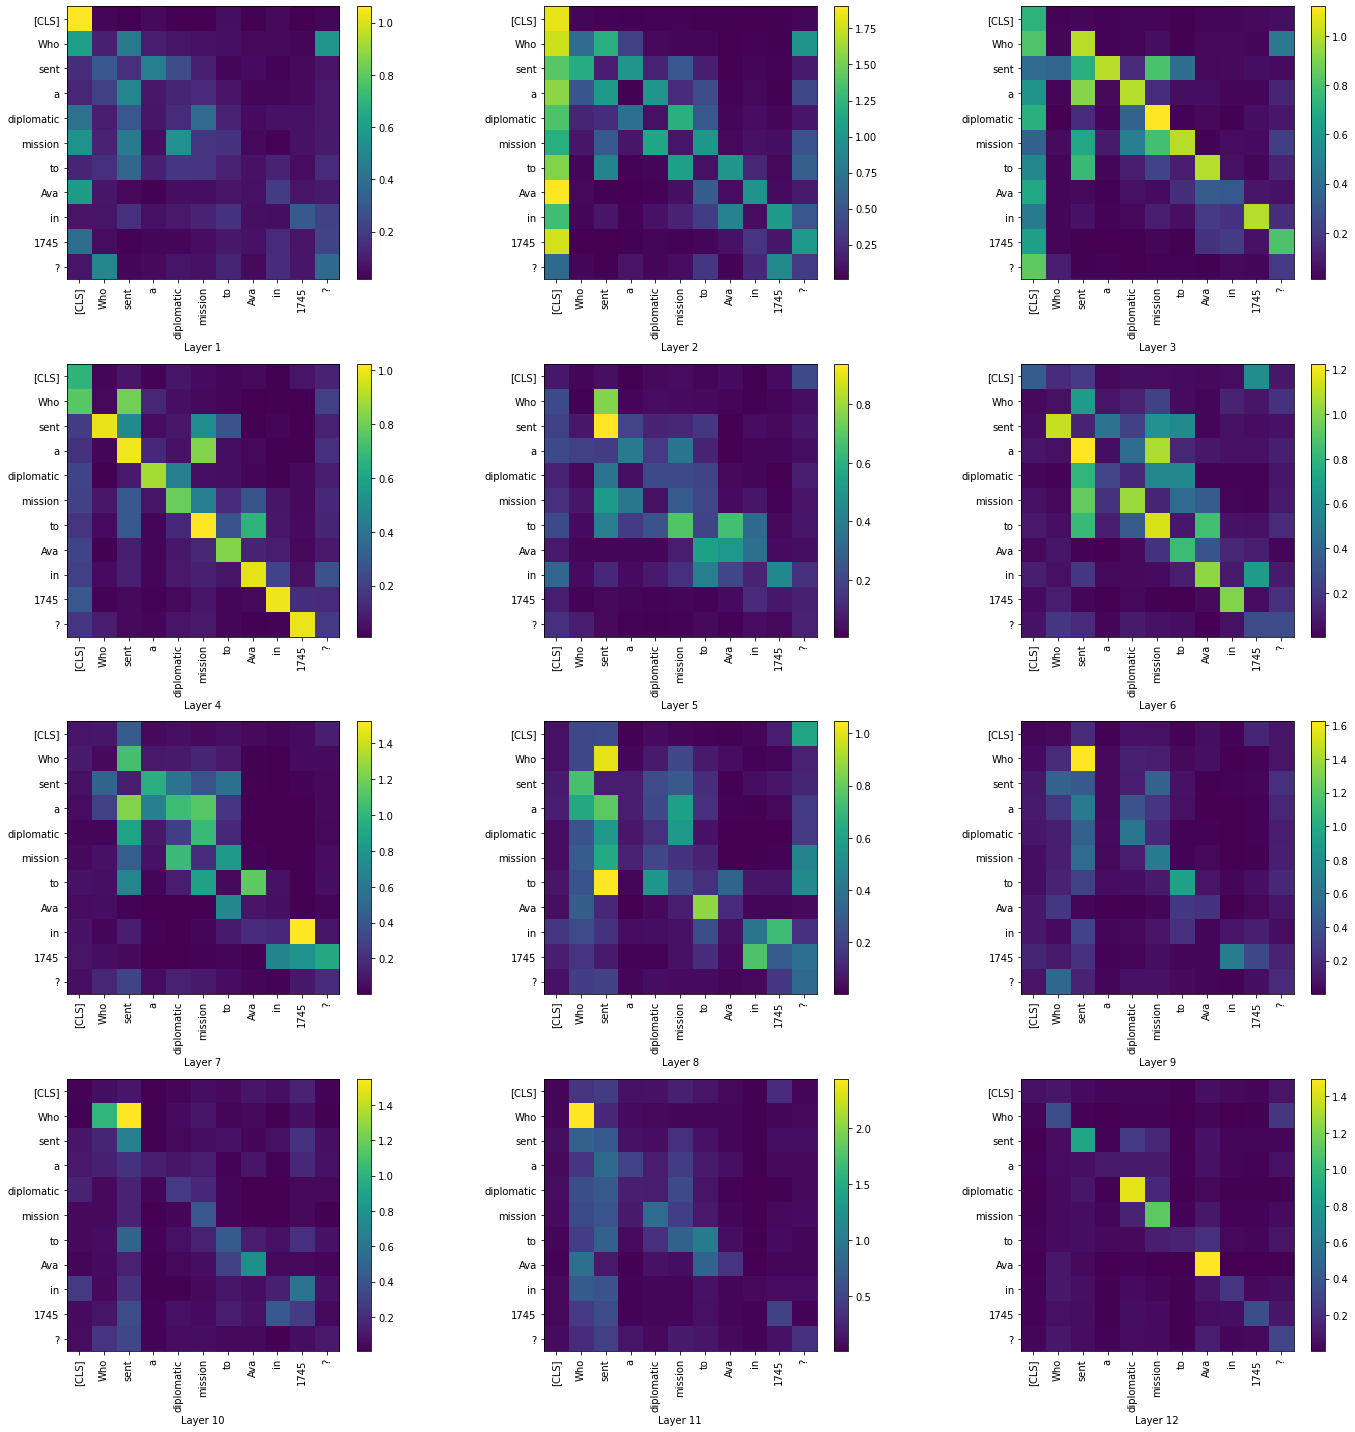

In [148]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')

### BioBERT

In [149]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("gerardozq/biobert_v1.1_pubmed-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("gerardozq/biobert_v1.1_pubmed-finetuned-squad", output_attentions=True)

model = model.to(device)

In [150]:
em_total, f1_total = evaluate_model(model, val_all, tokenizer, device, answer_getter=drop_answergetter)

100%|██████████| 2000/2000 [01:13<00:00, 27.19it/s]


In [151]:
print(em_total)
print(f1_total)

0.1525
0.27095799474119053


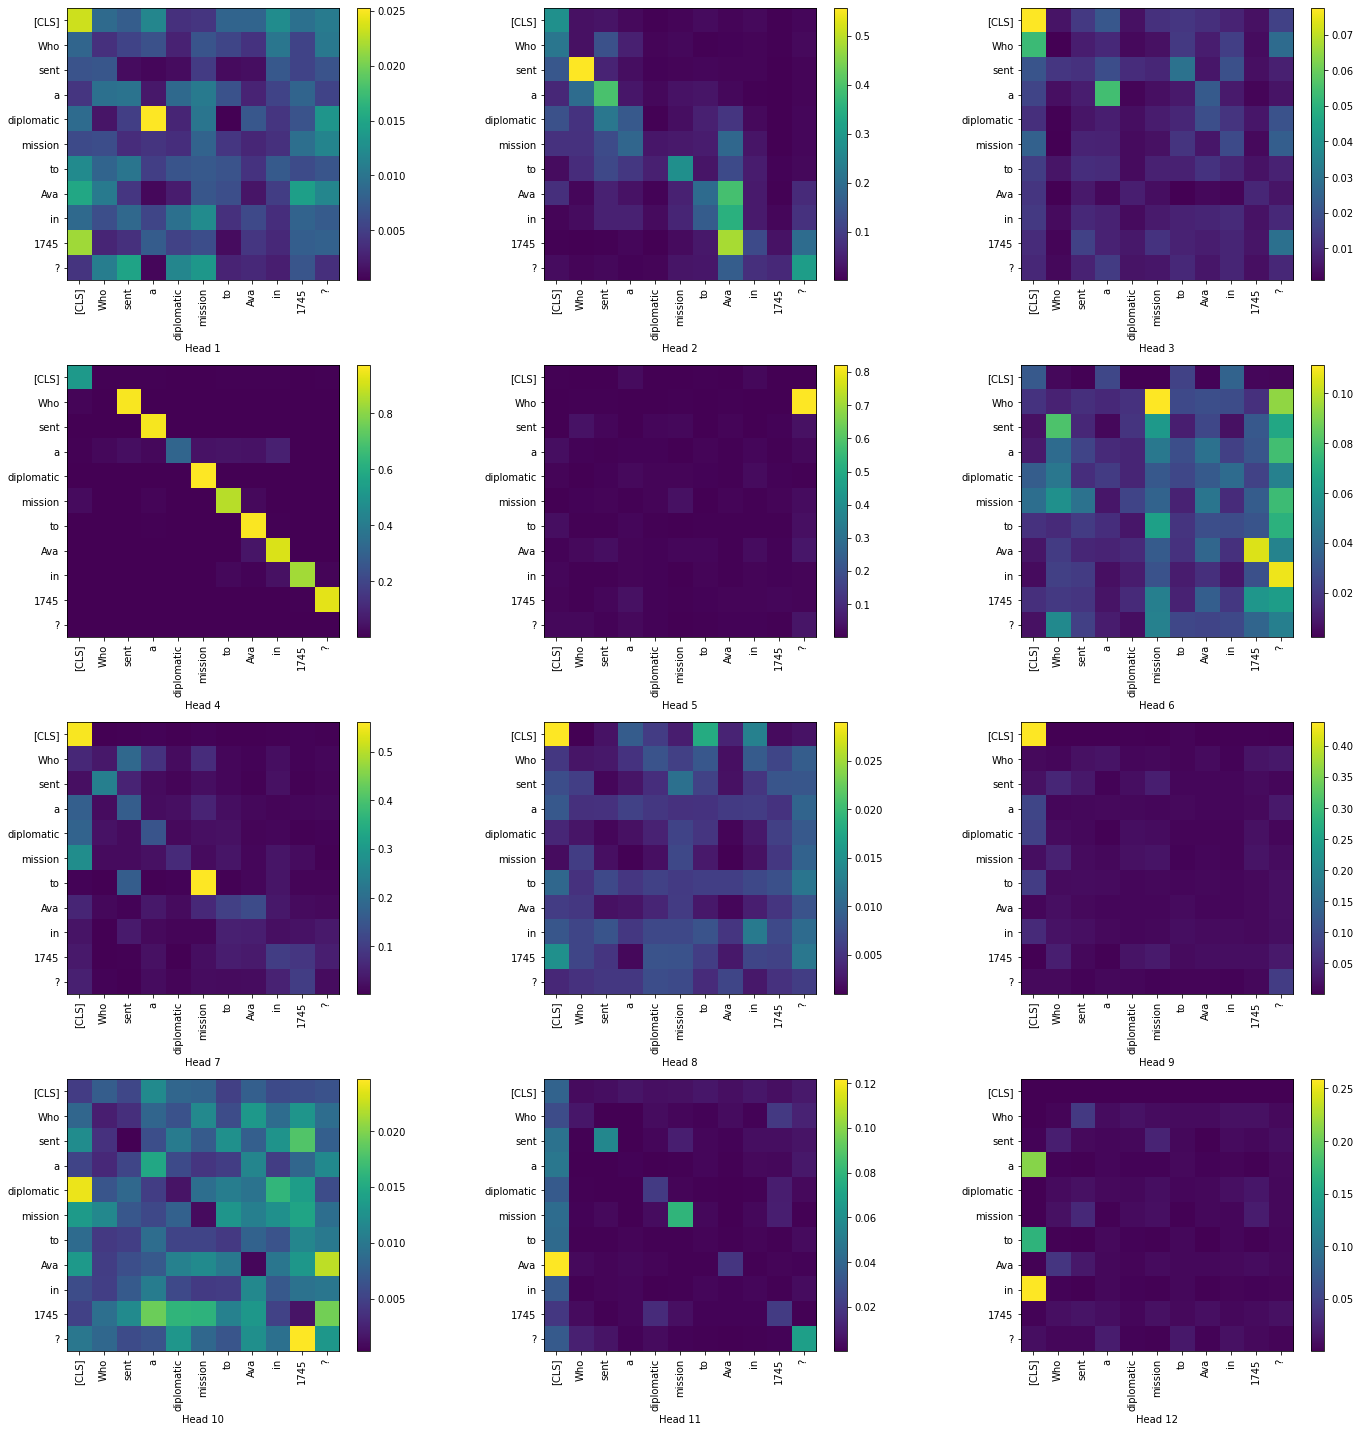

In [152]:
answer=val_answers[10]["text"]
pred, attn_score, input_ids, _ = eval_qa(val_questions[10], val_contexts[10], answer, 512, tokenizer, model, device)

layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

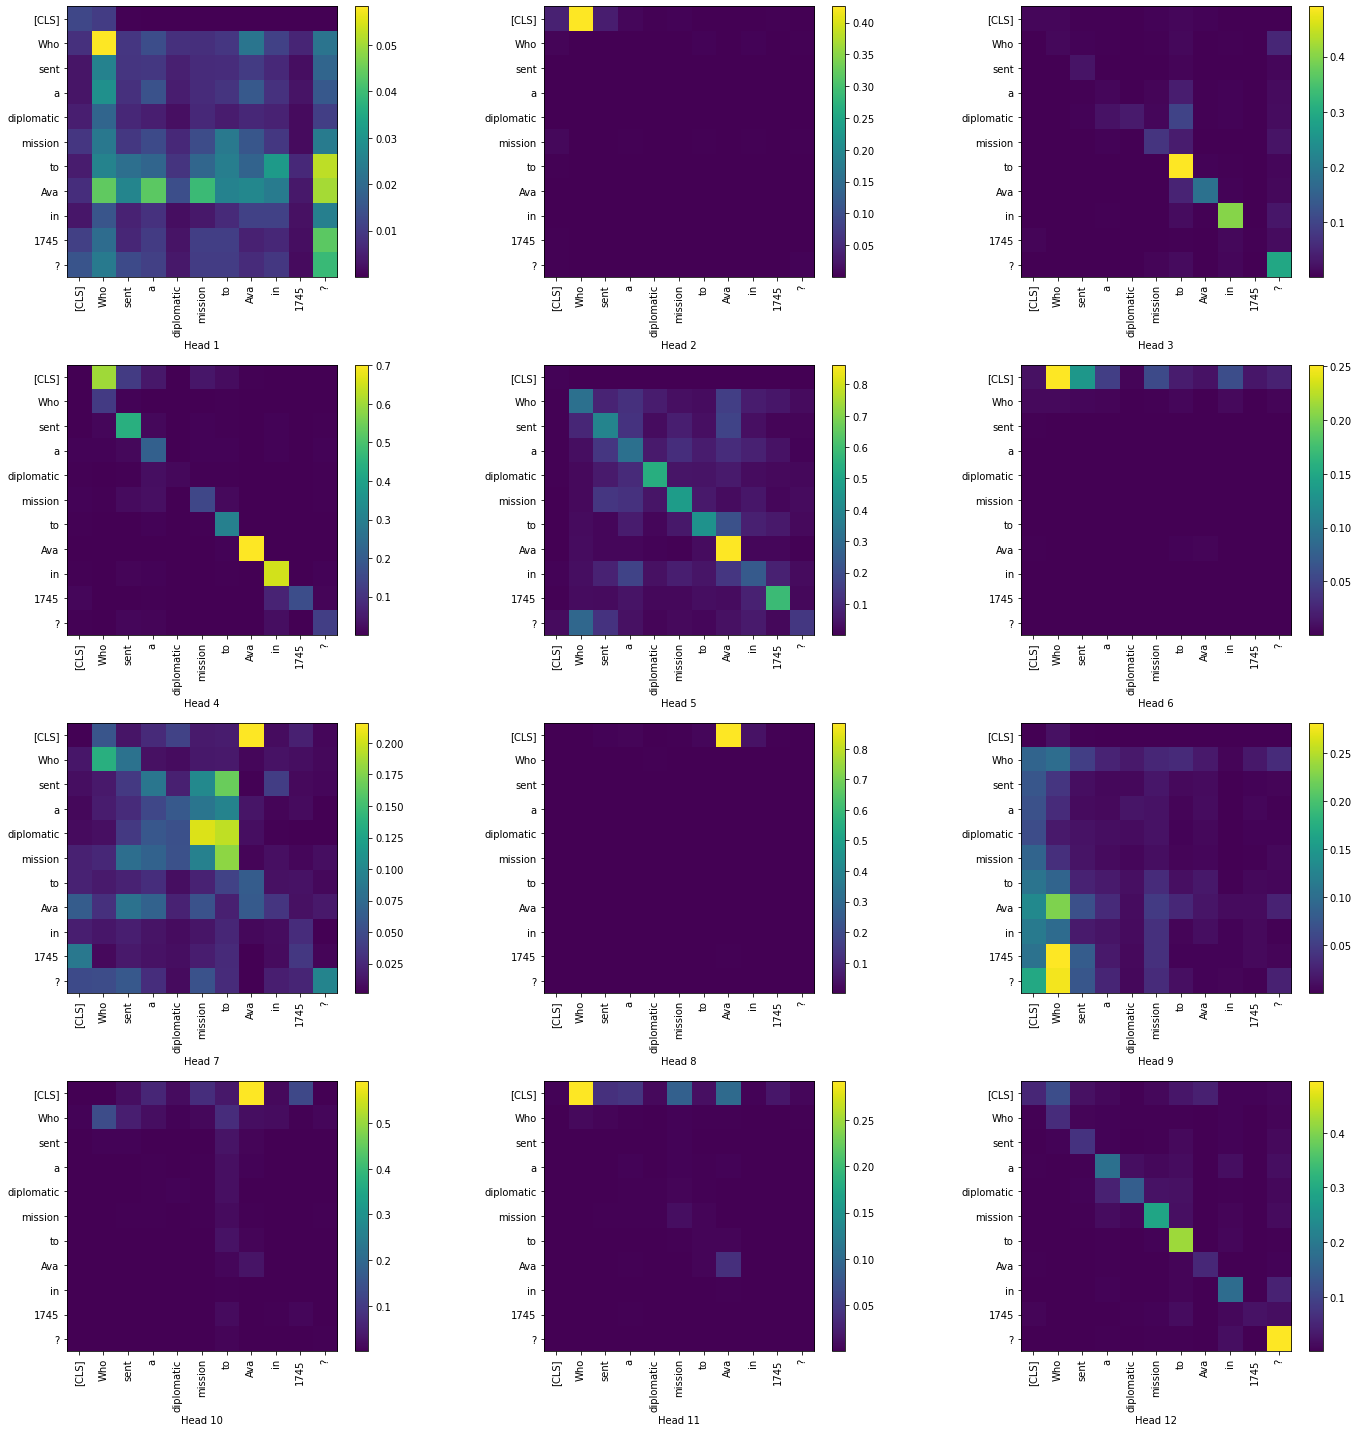

In [153]:
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

In [154]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [155]:
output_attentions_all = torch.stack(attn_score_qn)

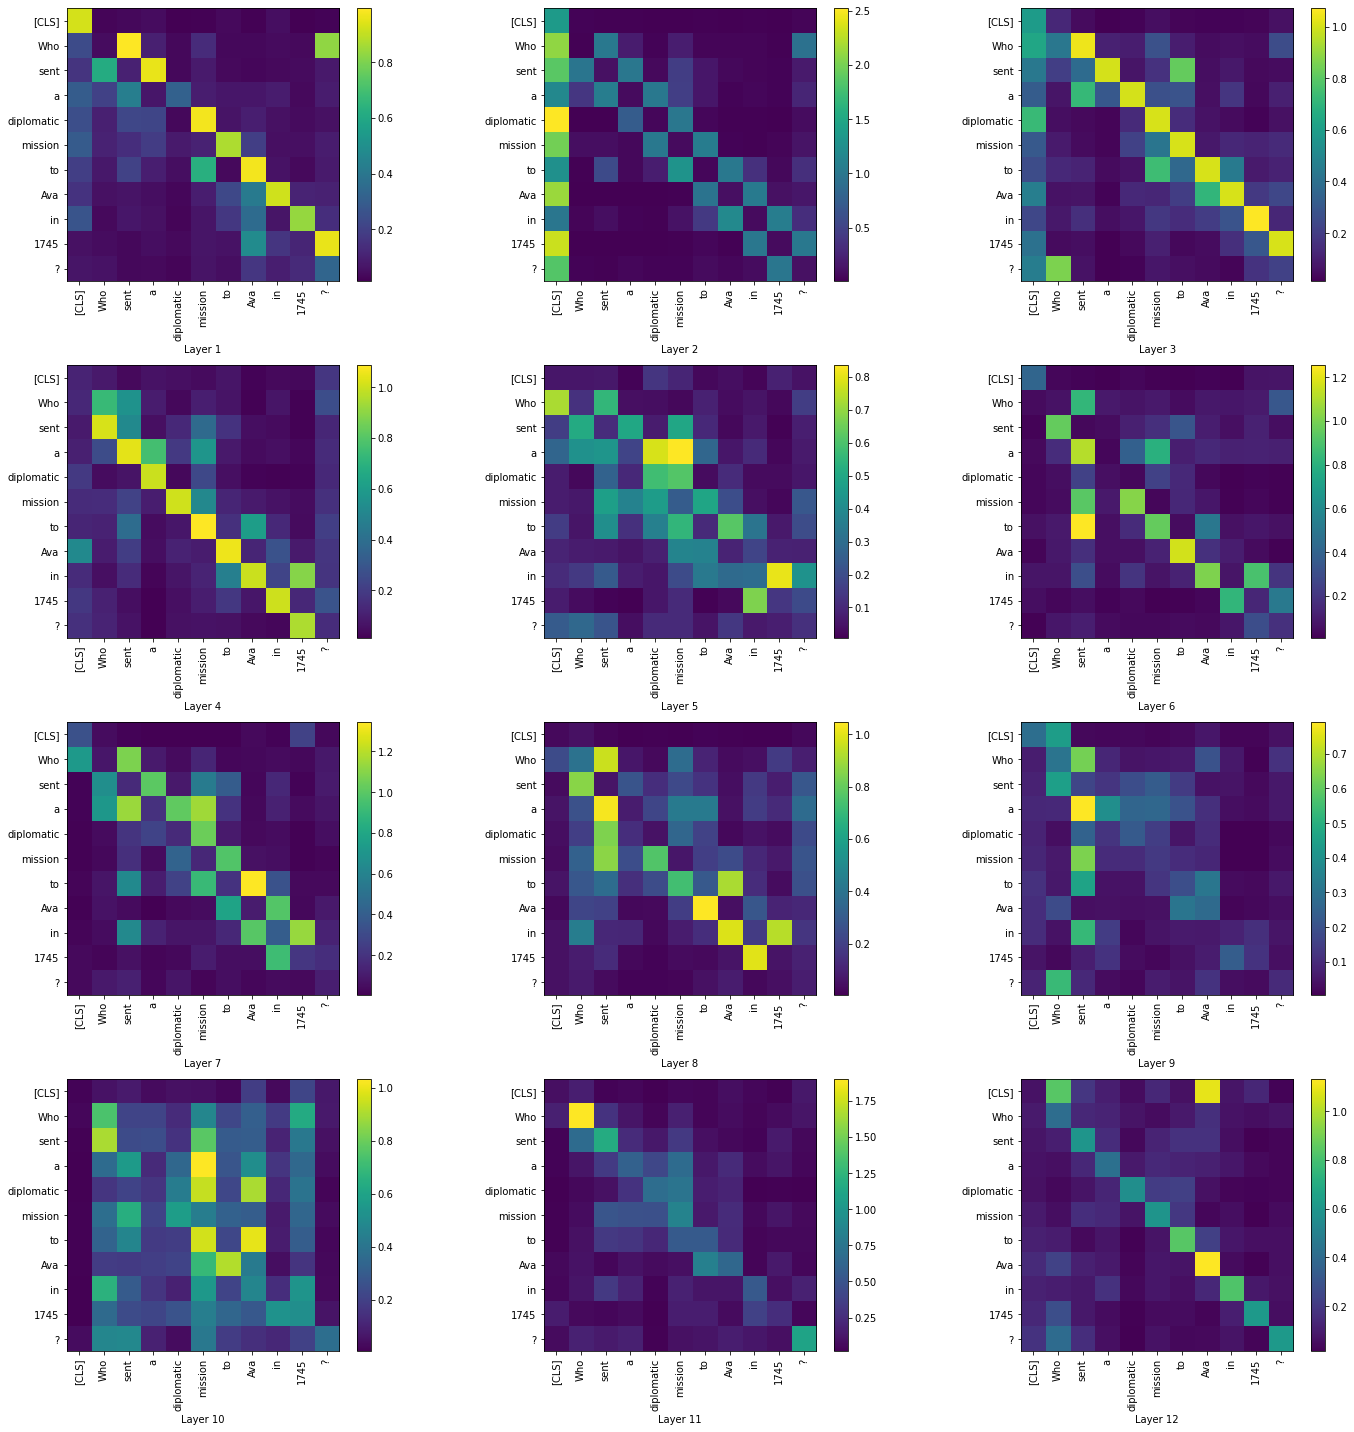

In [156]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')

### Finetuning BioBERT

In [ ]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer
        if type(answer['answer_start']) == list:
          if len(answer['answer_start']) > 0:
            answer['answer_start'] = answer['answer_start'][0]
          else:
            answer['answer_start'] = 0
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters
        else:
            answer['answer_end'] = end_idx

    # return answers, contexts

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [ ]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [ ]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # if None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [ ]:
import torch

class DROPDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = DROPDataset(train_encodings)
val_dataset = DROPDataset(val_encodings)

In [ ]:
from tqdm import tqdm

In [157]:
from torch.utils.data import DataLoader
from transformers import AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

for epoch in trange(3):
    for batch in tqdm(train_loader, total=len(train_loader)):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

 65%|██████▍   | 810/1250 [11:38<06:21,  1.15it/s]

100%|██████████| 3/3 [53:49<00:00, 1076.62s/it]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [158]:
torch.save(model.state_dict(), "/content/drive/MyDrive/DL_CovidQA/biobert_base_cased_drop_finetuned.pt")

In [159]:
em_total, f1_total = evaluate_model(model, val_all, tokenizer, device, answer_getter=drop_answergetter)

100%|██████████| 2000/2000 [01:17<00:00, 25.87it/s]


In [160]:
print(em_total)
print(f1_total)

0.2915
0.41246257066188174


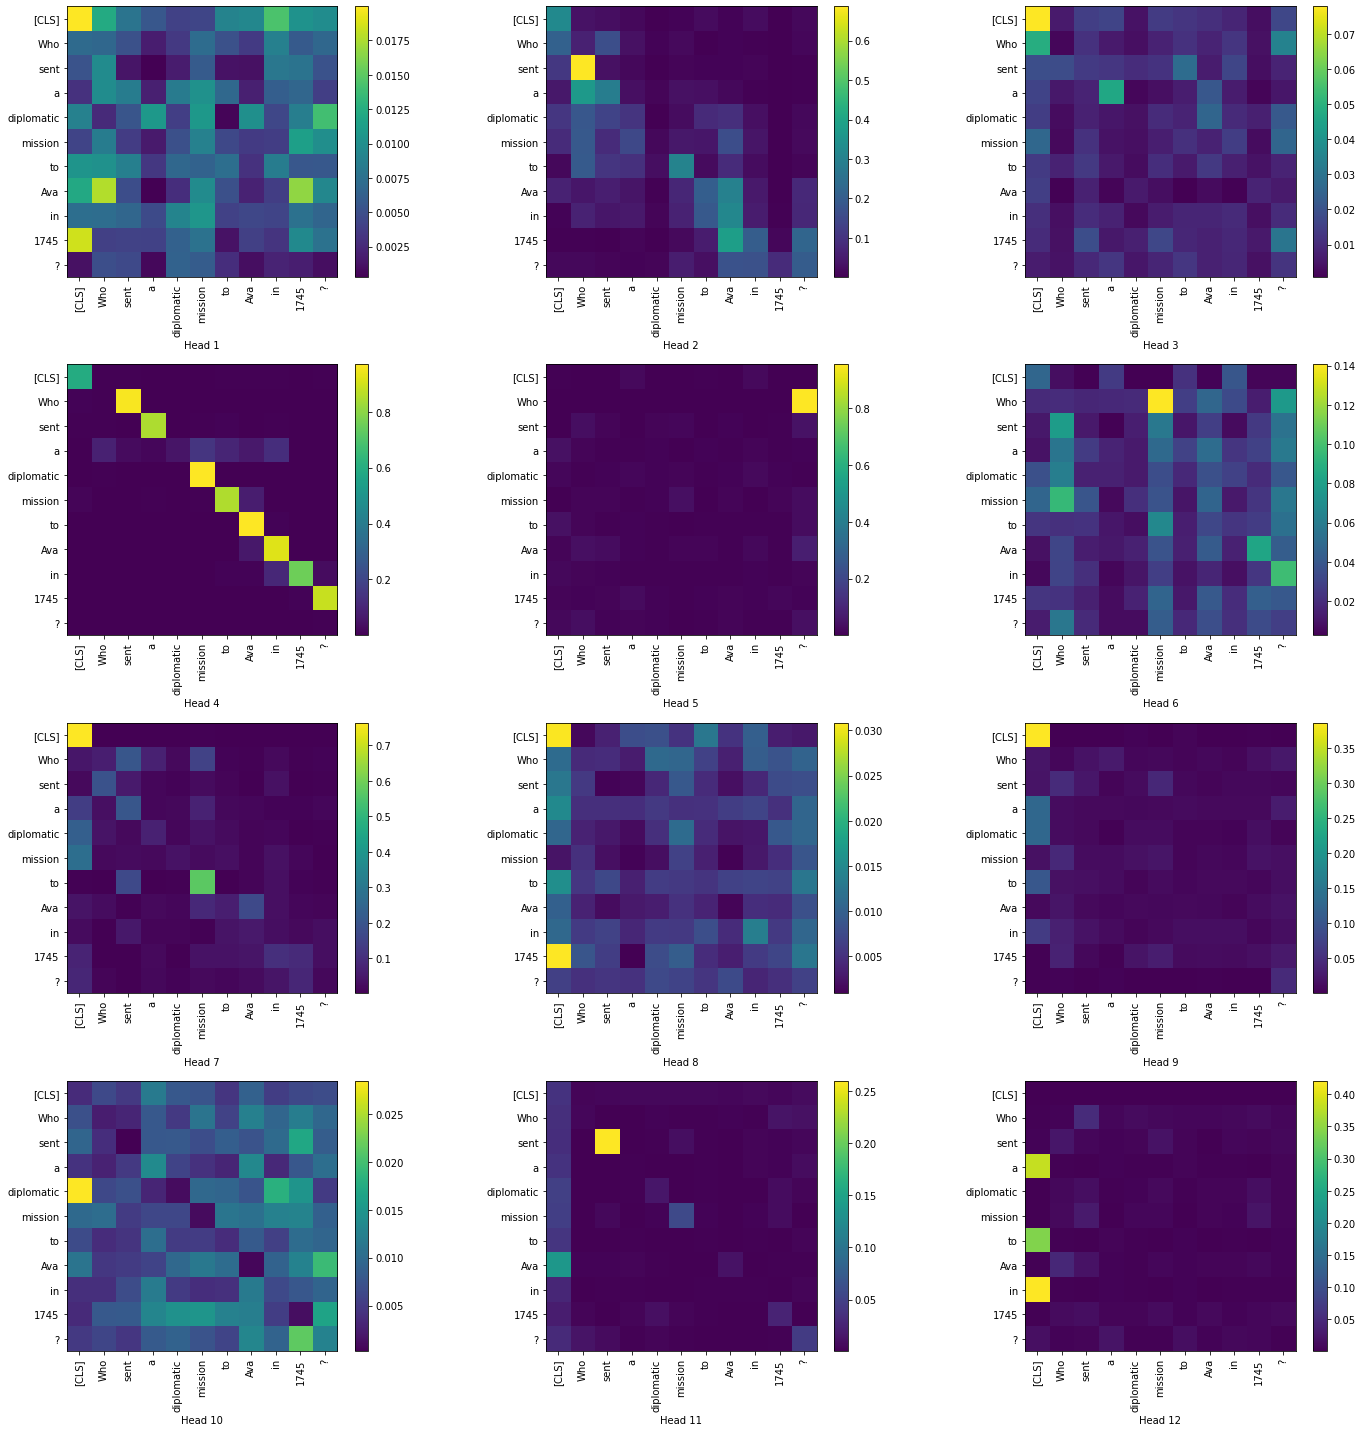

In [161]:
answer=val_answers[10]["text"]
pred, attn_score, input_ids, _ = eval_qa(val_questions[10], val_contexts[10], answer, 512, tokenizer, model, device)

layer = 0
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

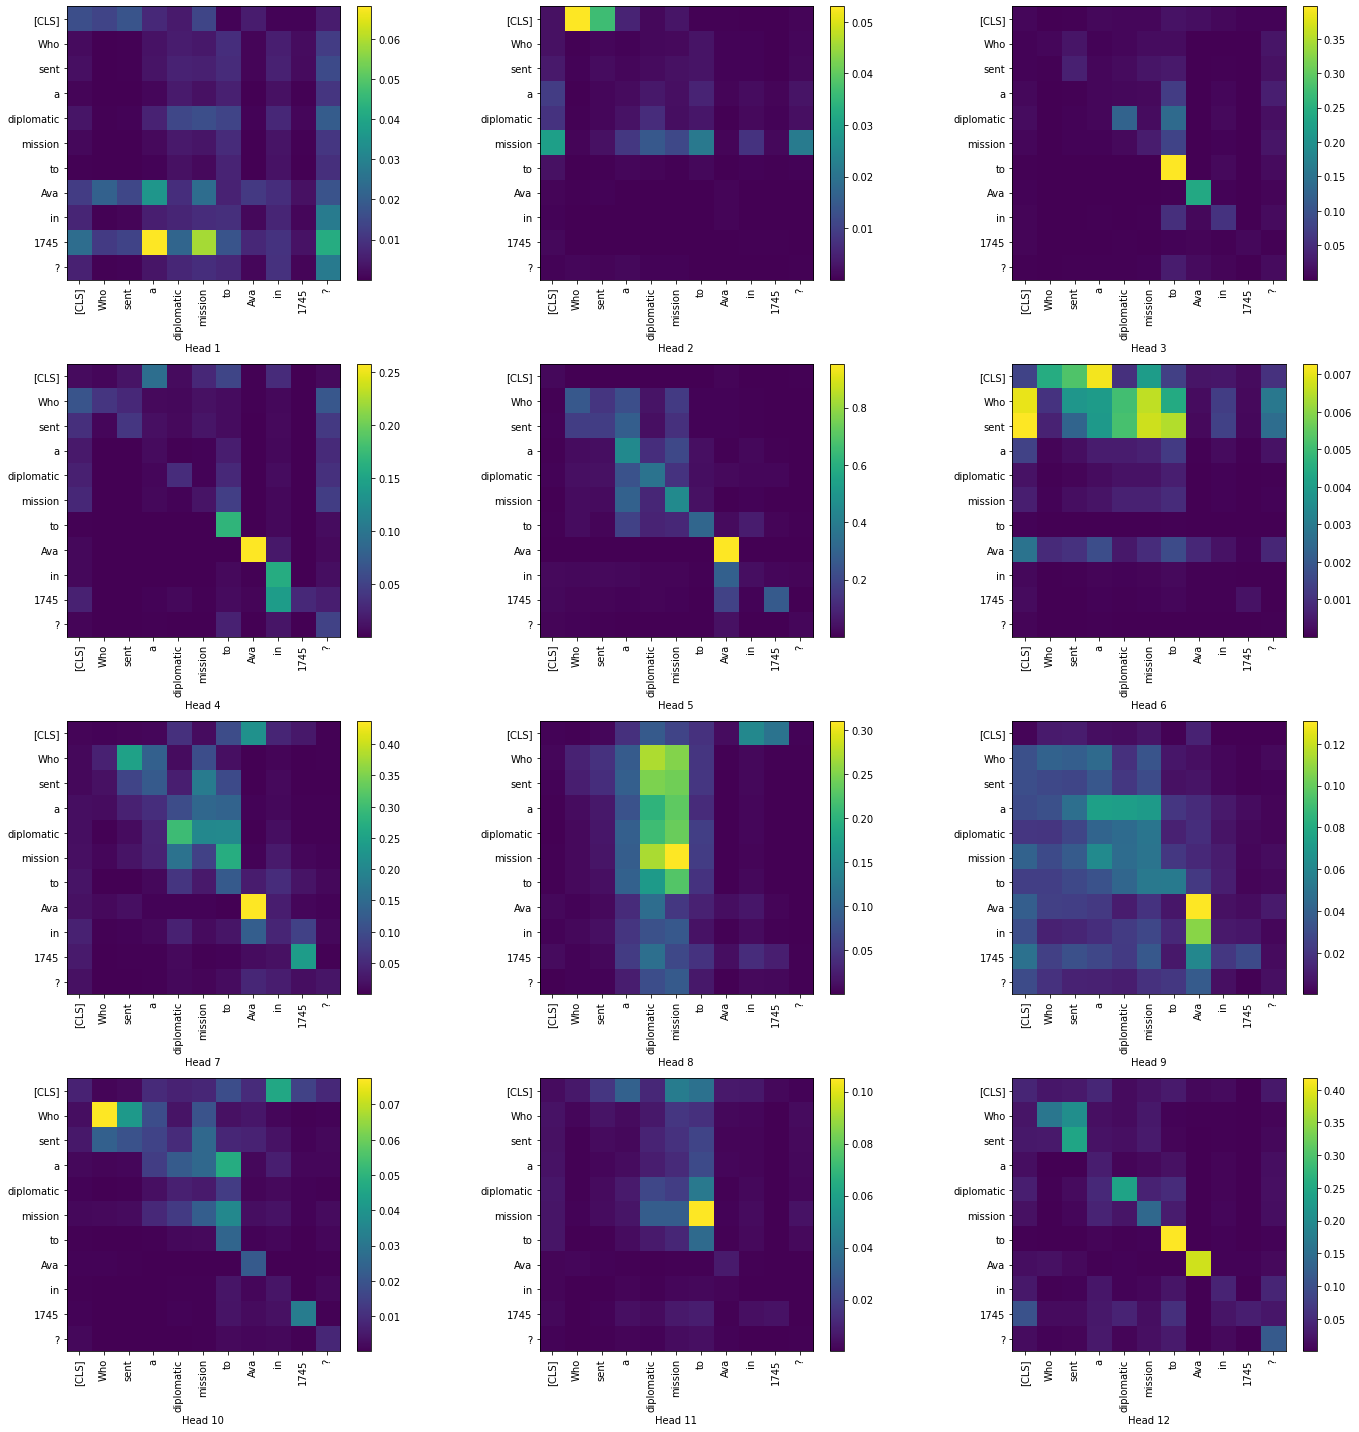

In [162]:
layer = 11
question_end = torch.where(input_ids[0] == tokenizer.sep_token_id)[0][0]
question_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:question_end])
visualize_token2token_scores(attn_score[layer][:, :, :question_end, :question_end].squeeze().detach().cpu().numpy(), question_tokens)

In [163]:
attn_score_qn = (attn_score[0][:, :, :question_end, :question_end], attn_score[1][:, :, :question_end, :question_end], attn_score[2][:, :, :question_end, :question_end], attn_score[3][:, :, :question_end, :question_end], attn_score[4][:, :, :question_end, :question_end], attn_score[5][:, :, :question_end, :question_end], attn_score[6][:, :, :question_end, :question_end], attn_score[7][:, :, :question_end, :question_end], attn_score[8][:, :, :question_end, :question_end], attn_score[9][:, :, :question_end, :question_end], attn_score[10][:, :, :question_end, :question_end], attn_score[11][:, :, :question_end, :question_end])

In [164]:
output_attentions_all = torch.stack(attn_score_qn)

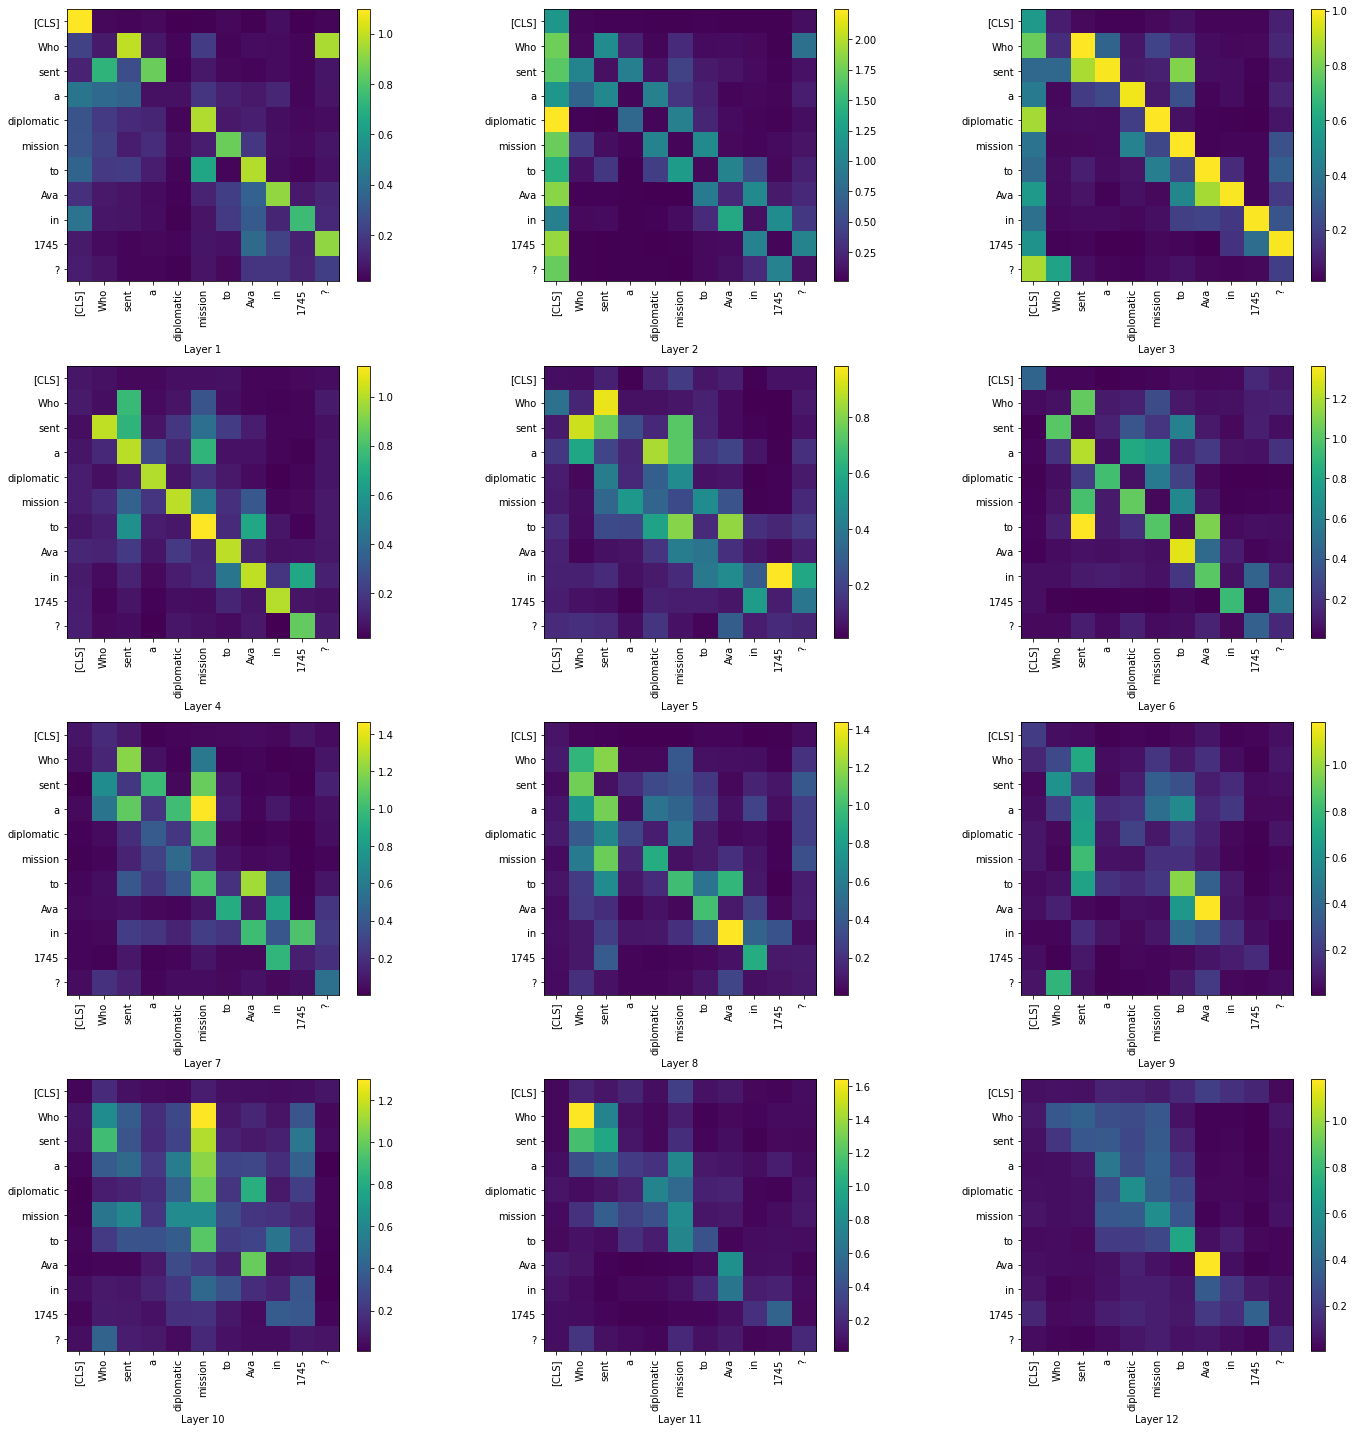

In [165]:
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(), question_tokens, x_label_name='Layer')